# Enhanced Exploratory Data Analysis for Hypertension Medication Adherence

This notebook presents a comprehensive exploratory data analysis of hypertension medication adherence patterns. The analysis examines demographic factors, medication types, healthcare plans, temporal patterns, and economic aspects that influence patient adherence to hypertension medications. Key findings include age-related adherence patterns, medication refill behaviors, cost implications, and potential intervention strategies. This work serves as a foundation for developing targeted approaches to improve medication adherence among hypertension patients.

In [ ]:
# Import necessary libraries with clear organization by functionality
# Data manipulation and analysis libraries
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter

# Statistical analysis
import statsmodels.api as sm
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration to suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set consistent visualization style for professional presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Loading and Initial Exploration
This section loads the hypertension dataset, performs initial data cleaning, and explores the basic characteristics of the data.



In [ ]:
def load_and_preprocess_data(filepath):
    """
    Load and preprocess the hypertension dataset.

    Parameters:
    -----------
    filepath : str
        Path to the dataset CSV file

    Returns:
    --------
    df : pandas DataFrame
        Preprocessed DataFrame with converted datatypes and cleaned columns
    """
    # Load the dataset
    df = pd.read_csv(filepath)

    # Clean column names
    df.columns = [col.strip() for col in df.columns]

    # Convert date columns to datetime
    date_columns = ['SERVICE DATE', 'ASSESS DATE', 'DATE RECEIVED', 'BIRTHDATE']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')

    # Convert numeric columns
    numeric_cols = ['AMOUNT CLAIMED', 'PAID FROM RISK AMT', 'TOTAL AMOUNT PAID',
                   'ADHERENCE', 'CURRENT AGE']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# Load the hypertension adherence dataset
filepath = "/content/HTN Adherence Data.csv"
df = load_and_preprocess_data(filepath)

# Display dataset information
print("Dataset Overview:")
print(f"• Total records: {df.shape[0]:,}")
print(f"• Variables: {df.shape[1]}")
print(f"• Unique patients: {df['MEMBER'].nunique():,}")

# Display summary of missing values
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_pct.round(2)
})
print("\nMissing Values Summary:")
print(missing_summary[missing_summary['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

# Display sample data
print("\nSample Data:")
display(df.head(3))

Dataset Overview:
• Total records: 218,816
• Variables: 41
• Unique patients: 15,912

Missing Values Summary:
                      Missing Values  Percentage (%)
DUPLICATE CLAIM LINE          218816          100.00
DUPLICATE CLAIM               218816          100.00
SCRIPT CODE                   218815          100.00
AUTH NO                        69931           31.96
AS AT NETWORKS                 54162           24.75
REFERRING PRACTICE              3561            1.63
INV REF                            3            0.00

Sample Data:


,MEMBER,INO,PZTIQNT NZXQ,ADHERENCE,GENDER,PRACTICE NO,DIS,PROVIDER,AS AT NETWORKS,REFERRING PRACTICE,...,DL,CLAIM NO,CLAIM LINE NO,DUPLICATE CLAIM,DUPLICATE CLAIM LINE,OPTION NAME,PAPER/EDI,ASSESSOR NAME,BIRTHDATE,CURRENT AGE
0,98785554,0,XR TZPIWZ GOTORZ,1,M,877395,60,96827 CIMAS FOURTH STREET PHARMACY,CIMAS PHARMACIES (2123),861243.0,...,N,2351311,5319229,NaN,NaN,STUDYMATE PRIVATE,EDI,CIMAS_HEALTH263 ADMIN,1996-12-16,26
1,98785678,0,XS XQRCY XUTQPFZ,6,F,877344,60,92398 CIMAS HCC MUTARE PHARMACY,CIMAS PHARMACIES (2123),866776.0,...,N,1978548,4453013,NaN,NaN,STUDYMATE PRIVATE,EDI,CIMAS_HEALTH263 ADMIN,1965-12-07,57
2,98785678,0,XS XQRCY XUTQPFZ,6,F,877344,60,92398 CIMAS HCC MUTARE PHARMACY,CIMAS PHARMACIES (2123),866776.0,...,N,1978548,4453009,NaN,NaN,STUDYMATE PRIVATE,EDI,CIMAS_HEALTH263 ADMIN,1965-12-07,57


# 2. Creating Patient-Level Dataset
Since our analysis will focus on patient-level patterns rather than individual records, we'll aggregate the data to patient level.

In [ ]:
def create_patient_level_dataset(df):
    """
    Aggregate transaction-level data to patient-level.

    Parameters:
    -----------
    df : pandas DataFrame
        Original transaction-level data

    Returns:
    --------
    patient_df : pandas DataFrame
        Patient-level dataset with aggregated metrics
    """
    # Create age groups for analysis
    age_bins = [20, 30, 40, 50, 60, 70, 80, 100]
    age_labels = ['20-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
    df['Age_Group'] = pd.cut(df['CURRENT AGE'], bins=age_bins, labels=age_labels, right=False)

    # Calculate total medication claims and costs per patient
    patient_df = df.groupby('MEMBER').agg({
        'ADHERENCE': 'first',  # Adherence score
        'GENDER': 'first',  # Gender
        'CURRENT AGE': 'first',  # Age
        'Age_Group': 'first',  # Age group
        'OPTION NAME': 'first',  # Healthcare plan
        'AMOUNT CLAIMED': 'sum',  # Total amount claimed
        'CODE DESCRIPTION': lambda x: len(set(x)),  # Number of unique medications
        'SERVICE DATE': ['min', 'max', 'count']  # First visit, last visit, number of visits
    }).reset_index()

    # Rename columns for clarity
    patient_df.columns = ['MEMBER', 'ADHERENCE', 'GENDER', 'CURRENT_AGE', 'AGE_GROUP',
                         'HEALTHCARE_PLAN', 'TOTAL_CLAIMED', 'UNIQUE_MEDS',
                         'FIRST_VISIT', 'LAST_VISIT', 'VISIT_COUNT']

    # Calculate observation period in months (rounded)
    patient_df['OBSERVATION_PERIOD_MONTHS'] = round((patient_df['LAST_VISIT'] -
                                                    patient_df['FIRST_VISIT']).dt.days / 30, 1)

    # Create adherence categories
    patient_df['ADHERENCE_CATEGORY'] = patient_df['ADHERENCE'].apply(
        lambda x: 'Low (1-4)' if x <= 4 else ('Medium (5-8)' if x <= 8 else 'High (9-12)')
    )

    return patient_df

# Create patient-level dataset
patient_df = create_patient_level_dataset(df)

# Display patient dataset summary
print("Patient-Level Dataset Summary:")
print(f"• Number of patients: {len(patient_df):,}")
print(f"• Average adherence score: {patient_df['ADHERENCE'].mean():.2f}/12")
print(f"• Average age: {patient_df['CURRENT_AGE'].mean():.1f} years")
print(f"• Gender distribution: {100*patient_df['GENDER'].value_counts(normalize=True)['M']:.1f}% Male, {100*patient_df['GENDER'].value_counts(normalize=True)['F']:.1f}% Female")
adherence_categories = patient_df['ADHERENCE_CATEGORY'].value_counts(normalize=True).sort_index().to_dict()
# Multiply values in the dictionary by 100 to represent percentages
adherence_categories_pct = {k: v * 100 for k, v in adherence_categories.items()}
print(f"• Adherence categories: {adherence_categories_pct}")
# Display sample of patient dataset
display(patient_df.head(3))

Patient-Level Dataset Summary:
• Number of patients: 15,912
• Average adherence score: 6.43/12
• Average age: 56.0 years
• Gender distribution: 56.0% Male, 44.0% Female
• Adherence categories: {'High (9-12)': 39.08371040723982, 'Low (1-4)': 37.449723479135244, 'Medium (5-8)': 23.466566113624935}


,MEMBER,ADHERENCE,GENDER,CURRENT_AGE,AGE_GROUP,HEALTHCARE_PLAN,TOTAL_CLAIMED,UNIQUE_MEDS,FIRST_VISIT,LAST_VISIT,VISIT_COUNT,OBSERVATION_PERIOD_MONTHS,ADHERENCE_CATEGORY
0,92222365,1,F,48,41-50,PRIVATE HOSPITAL PLUS,21435.44,1,2022-09-16,2022-09-16,1,0.0,Low (1-4)
1,92222436,7,M,75,71-80,PRIVATE HOSPITAL PLUS,66322.61,5,2022-01-11,2022-11-24,18,10.6,Medium (5-8)
2,92222445,2,M,60,61-70,PRIVATE HOSPITAL PLUS,9031.21,3,2022-09-14,2022-11-15,3,2.1,Low (1-4)


# 3. Demographic Analysis
3.1 Age Distribution and Relationship with Adherence

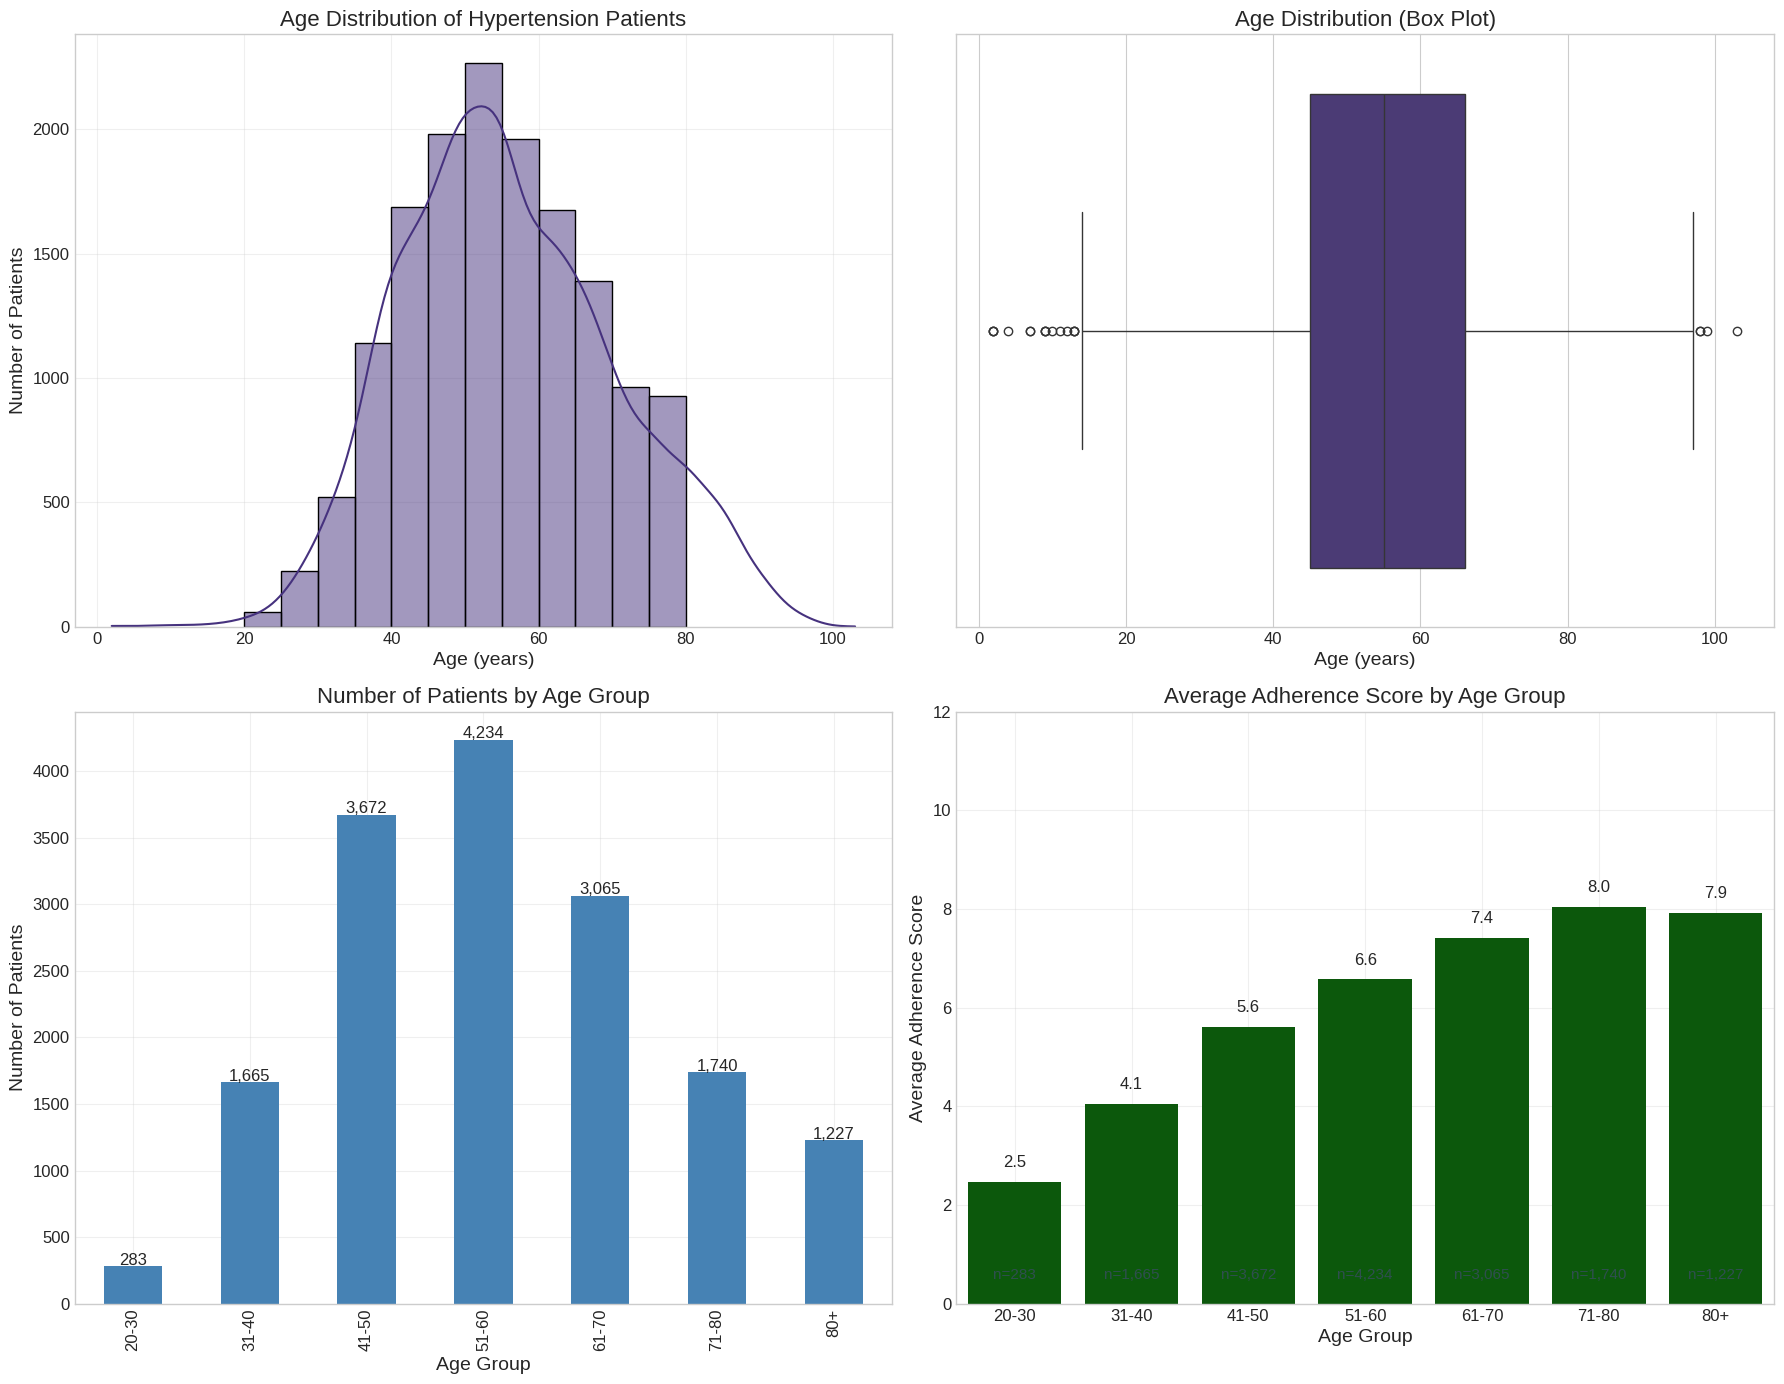

Correlation between age and adherence: 0.314

Regression Analysis: Age vs. Adherence
• Coefficient: 0.0846
• p-value: 0.0000
• R-squared: 0.0988
• Statistically significant relationship between age and adherence
• As age increases, adherence tends to increase


In [ ]:
def plot_age_distribution_and_adherence(patient_df):
    """
    Create visualizations for age distribution and its relationship with adherence.

    Parameters:
    -----------
    patient_df : pandas DataFrame
        Patient-level dataset
    """
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Plot 1: Age histogram
    sns.histplot(patient_df['CURRENT_AGE'], bins=range(20, 85, 5), kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Age Distribution of Hypertension Patients', fontsize=16)
    axes[0, 0].set_xlabel('Age (years)', fontsize=14)
    axes[0, 0].set_ylabel('Number of Patients', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Age boxplot
    sns.boxplot(x=patient_df['CURRENT_AGE'], ax=axes[0, 1])
    axes[0, 1].set_title('Age Distribution (Box Plot)', fontsize=16)
    axes[0, 1].set_xlabel('Age (years)', fontsize=14)

    # Plot 3: Age group counts
    age_counts = patient_df['AGE_GROUP'].value_counts().sort_index()
    age_counts.plot(kind='bar', ax=axes[1, 0], color='steelblue')
    axes[1, 0].set_title('Number of Patients by Age Group', fontsize=16)
    axes[1, 0].set_xlabel('Age Group', fontsize=14)
    axes[1, 0].set_ylabel('Number of Patients', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)

    # Add count labels
    for i, count in enumerate(age_counts.values):
        axes[1, 0].text(i, count + 10, f"{count:,}", ha='center', fontsize=12)

    # Plot 4: Adherence by age group
    adherence_by_age = patient_df.groupby('AGE_GROUP')['ADHERENCE'].agg(['mean', 'count']).reset_index()
    sns.barplot(x='AGE_GROUP', y='mean', data=adherence_by_age, ax=axes[1, 1], color='darkgreen')
    axes[1, 1].set_title('Average Adherence Score by Age Group', fontsize=16)
    axes[1, 1].set_xlabel('Age Group', fontsize=14)
    axes[1, 1].set_ylabel('Average Adherence Score', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0, 12)

    # Add value labels and sample size
    for i, row in adherence_by_age.iterrows():
        axes[1, 1].text(i, row['mean'] + 0.3, f"{row['mean']:.1f}", ha='center', fontsize=12)
        axes[1, 1].text(i, 0.5, f"n={row['count']:,}", ha='center', fontsize=11, color='darkslategray')

    plt.tight_layout()
    plt.show()

    # Calculate and display age-adherence correlation
    age_adherence_corr = patient_df[['CURRENT_AGE', 'ADHERENCE']].corr().iloc[0, 1]
    print(f"Correlation between age and adherence: {age_adherence_corr:.3f}")

    # Perform statistical test: regression analysis
    X = sm.add_constant(patient_df['CURRENT_AGE'])
    y = patient_df['ADHERENCE']
    model = sm.OLS(y, X).fit()

    print("\nRegression Analysis: Age vs. Adherence")
    print(f"• Coefficient: {model.params[1]:.4f}")
    print(f"• p-value: {model.pvalues[1]:.4f}")
    print(f"• R-squared: {model.rsquared:.4f}")

    # Interpretation
    if model.pvalues[1] < 0.05:
        print("• Statistically significant relationship between age and adherence")
        if model.params[1] > 0:
            print("• As age increases, adherence tends to increase")
        else:
            print("• As age increases, adherence tends to decrease")
    else:
        print("• No statistically significant relationship between age and adherence")

# Execute age analysis
plot_age_distribution_and_adherence(patient_df)

3.2 Gender Analysis


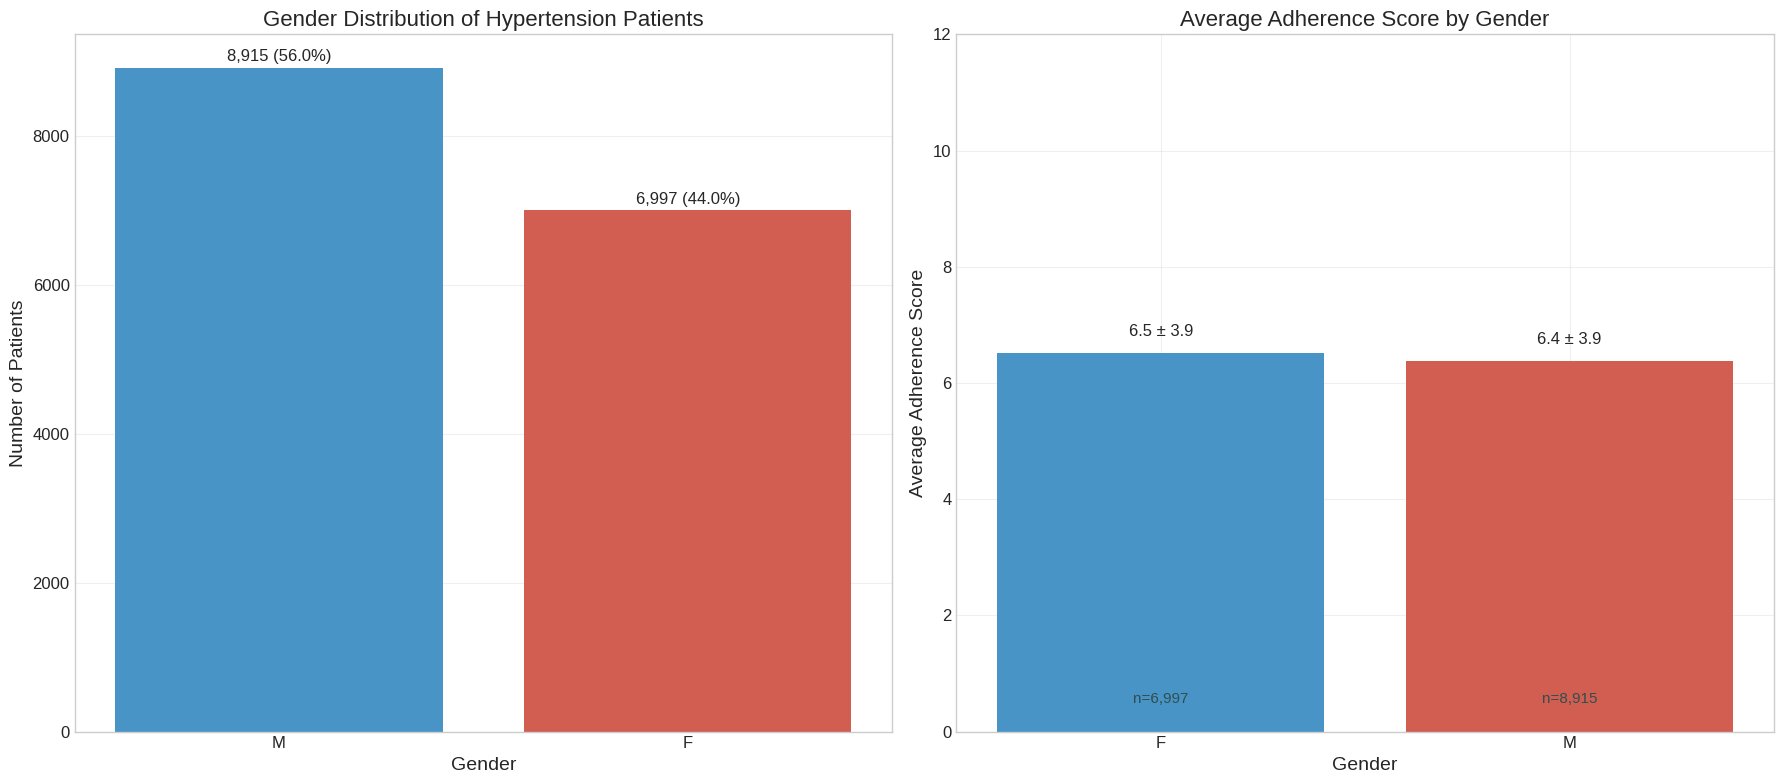

Gender Analysis:
• Males: 8,915 patients, Average adherence: 6.37
• Females: 6,997 patients, Average adherence: 6.51
• T-test result: t=-2.295, p=0.022
• Statistically significant difference in adherence between genders (p < 0.05)
• Females show significantly higher adherence than males


In [ ]:
def analyze_gender_patterns(patient_df):
    """
    Analyze and visualize gender distribution and its relationship with adherence.

    Parameters:
    -----------
    patient_df : pandas DataFrame
        Patient-level dataset
    """
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Gender distribution
    gender_counts = patient_df['GENDER'].value_counts()
    colors = ['#3498db', '#e74c3c']  # Blue for male, red for female (or customize)

    # Plot 1: Gender distribution
    ax = sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=colors, ax=axes[0])
    axes[0].set_title('Gender Distribution of Hypertension Patients', fontsize=16)
    axes[0].set_xlabel('Gender', fontsize=14)
    axes[0].set_ylabel('Number of Patients', fontsize=14)
    axes[0].grid(True, axis='y', alpha=0.3)

    # Add count and percentage labels
    total = gender_counts.sum()
    for i, (gender, count) in enumerate(gender_counts.items()):
        percentage = 100 * count / total
        axes[0].text(i, count + 50, f"{count:,} ({percentage:.1f}%)",
                    ha='center', va='bottom', fontsize=12)

    # Plot 2: Adherence by gender
    adherence_by_gender = patient_df.groupby('GENDER')['ADHERENCE'].agg(['mean', 'count', 'std']).reset_index()
    sns.barplot(x='GENDER', y='mean', data=adherence_by_gender, palette=colors, ax=axes[1])
    axes[1].set_title('Average Adherence Score by Gender', fontsize=16)
    axes[1].set_xlabel('Gender', fontsize=14)
    axes[1].set_ylabel('Average Adherence Score', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 12)

    # Add value labels and sample size
    for i, row in adherence_by_gender.iterrows():
        axes[1].text(i, row['mean'] + 0.3, f"{row['mean']:.1f} ± {row['std']:.1f}",
                    ha='center', fontsize=12)
        axes[1].text(i, 0.5, f"n={row['count']:,}", ha='center', fontsize=11, color='darkslategray')

    plt.tight_layout()
    plt.show()

    # Statistical test: t-test for gender difference in adherence
    males = patient_df[patient_df['GENDER'] == 'M']['ADHERENCE']
    females = patient_df[patient_df['GENDER'] == 'F']['ADHERENCE']
    t_stat, p_value = stats.ttest_ind(males, females, equal_var=False)

    print("Gender Analysis:")
    print(f"• Males: {len(males):,} patients, Average adherence: {males.mean():.2f}")
    print(f"• Females: {len(females):,} patients, Average adherence: {females.mean():.2f}")
    print(f"• T-test result: t={t_stat:.3f}, p={p_value:.3f}")

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print(f"• Statistically significant difference in adherence between genders (p < {alpha})")
        if males.mean() > females.mean():
            print("• Males show significantly higher adherence than females")
        else:
            print("• Females show significantly higher adherence than males")
    else:
        print(f"• No statistically significant difference in adherence between genders (p > {alpha})")

# Execute gender analysis
analyze_gender_patterns(patient_df)

## 4. Medication Adherence Analysis

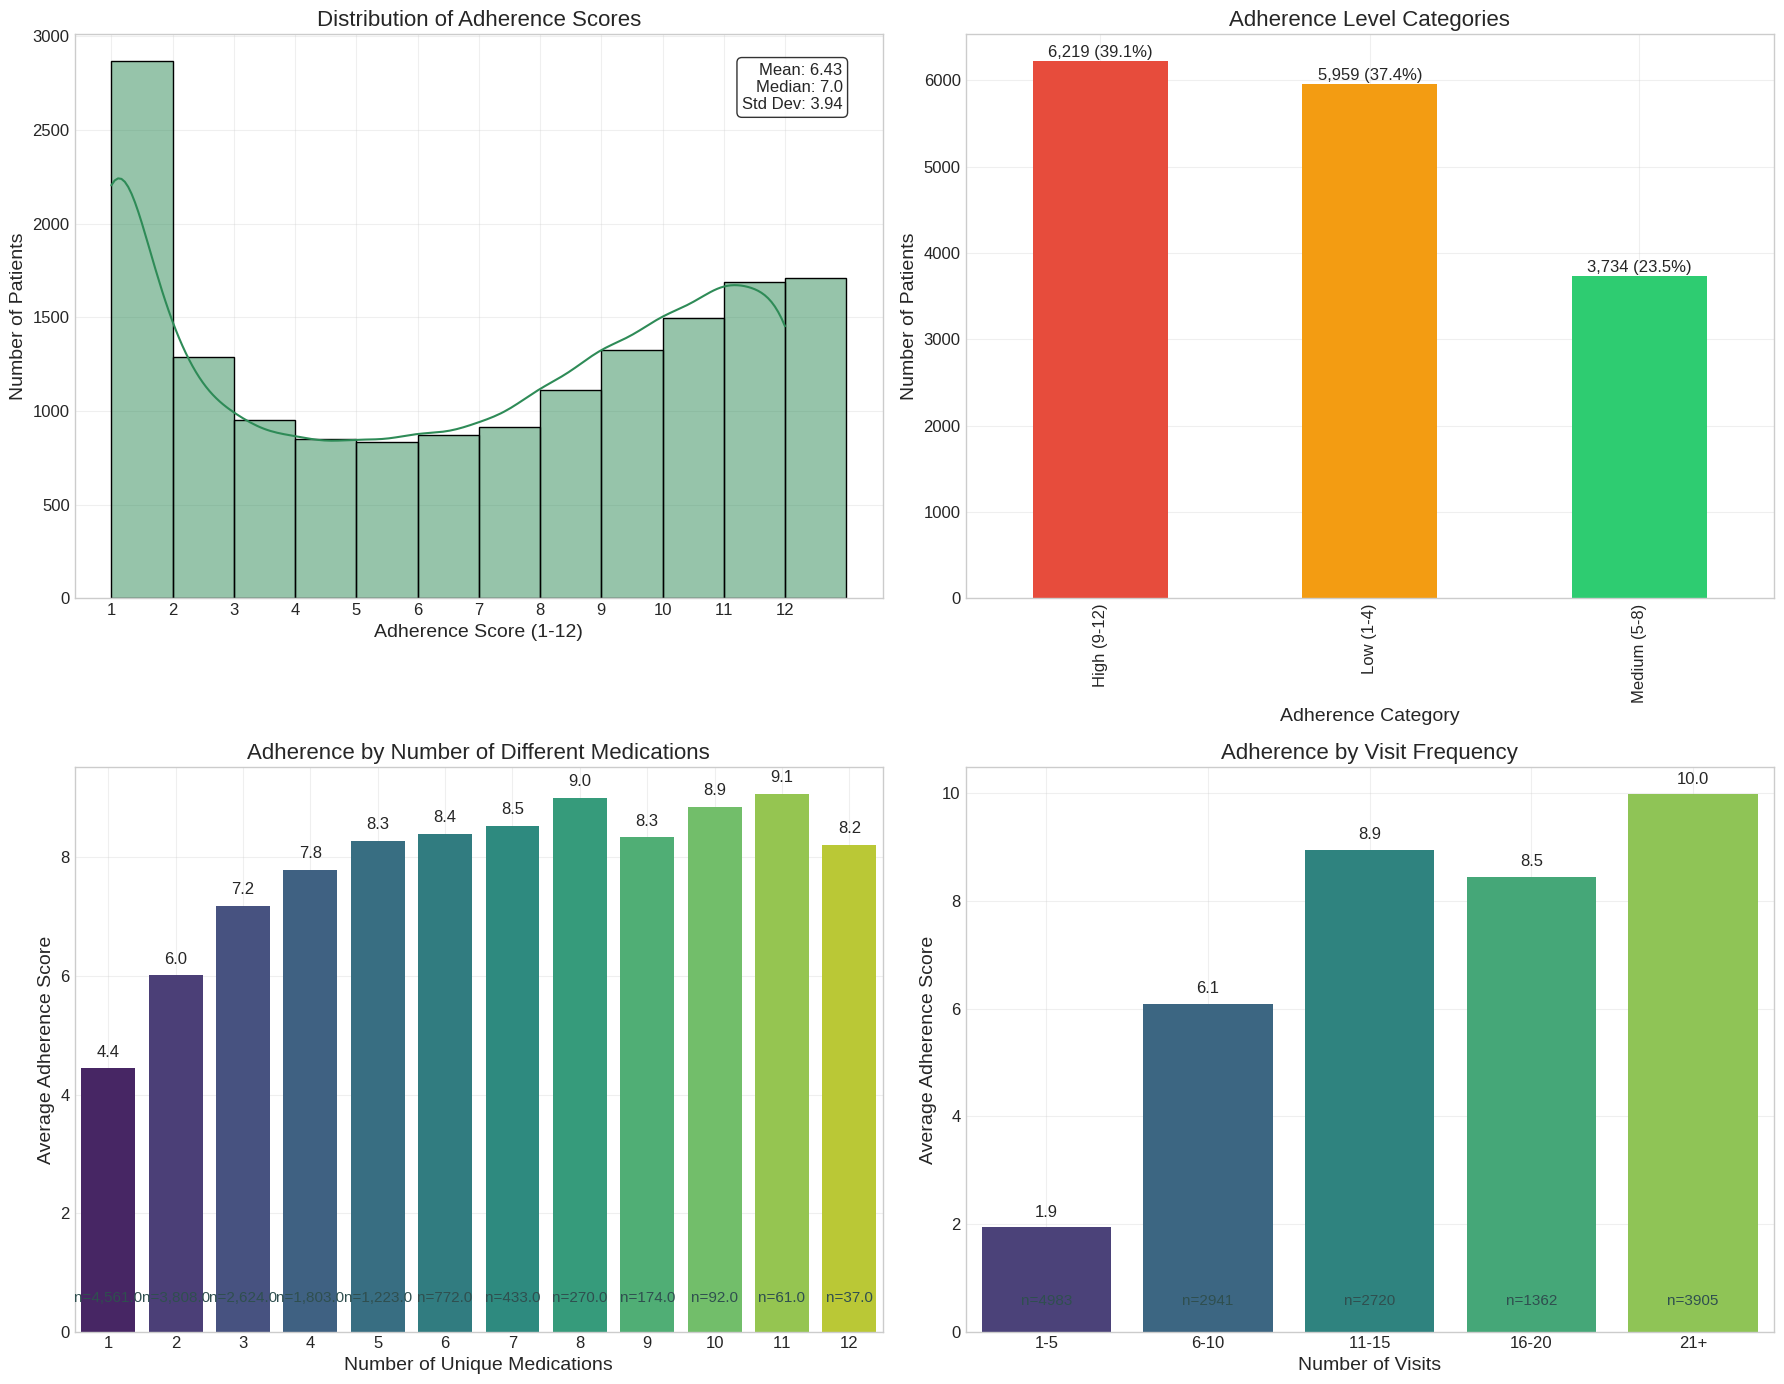

Correlations with Adherence:
• Current Age: 0.314
• Unique Meds: 0.336
• Visit Count: 0.672
• Total Claimed: 0.461


In [ ]:
def analyze_adherence_patterns(df, patient_df):
    """
    Analyze adherence patterns across the patient population.

    Parameters:
    -----------
    df : pandas DataFrame
        Original transaction-level data
    patient_df : pandas DataFrame
        Patient-level aggregated data
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Plot 1: Distribution of adherence scores
    sns.histplot(patient_df['ADHERENCE'], bins=range(1, 14), kde=True,
                color='seagreen', ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Adherence Scores', fontsize=16)
    axes[0, 0].set_xlabel('Adherence Score (1-12)', fontsize=14)
    axes[0, 0].set_ylabel('Number of Patients', fontsize=14)
    axes[0, 0].set_xticks(range(1, 13))
    axes[0, 0].grid(True, alpha=0.3)

    # Add descriptive statistics
    stats_text = (
        f"Mean: {patient_df['ADHERENCE'].mean():.2f}\n"
        f"Median: {patient_df['ADHERENCE'].median():.1f}\n"
        f"Std Dev: {patient_df['ADHERENCE'].std():.2f}"
    )
    axes[0, 0].text(0.95, 0.95, stats_text, transform=axes[0, 0].transAxes,
                  fontsize=12, verticalalignment='top', horizontalalignment='right',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plot 2: Adherence categories
    category_counts = patient_df['ADHERENCE_CATEGORY'].value_counts().sort_index()
    colors = ['#e74c3c', '#f39c12', '#2ecc71']  # Red, yellow, green for low, medium, high
    category_counts.plot(kind='bar', ax=axes[0, 1], color=colors)
    axes[0, 1].set_title('Adherence Level Categories', fontsize=16)
    axes[0, 1].set_xlabel('Adherence Category', fontsize=14)
    axes[0, 1].set_ylabel('Number of Patients', fontsize=14)
    axes[0, 1].grid(True, alpha=0.3)

    # Add count and percentage labels
    total = category_counts.sum()
    for i, (category, count) in enumerate(category_counts.items()):
        percentage = 100 * count / total
        axes[0, 1].text(i, count + 10, f"{count:,} ({percentage:.1f}%)",
                      ha='center', va='bottom', fontsize=12)

    # Plot 3: Adherence by number of medications
    patient_med_counts = patient_df.groupby('UNIQUE_MEDS')['ADHERENCE'].agg(['mean', 'count']).reset_index()
    # Filter groups with at least 30 patients for statistical reliability
    patient_med_counts = patient_med_counts[patient_med_counts['count'] >= 30]

    sns.barplot(x='UNIQUE_MEDS', y='mean', data=patient_med_counts, ax=axes[1, 0],
               palette='viridis')
    axes[1, 0].set_title('Adherence by Number of Different Medications', fontsize=16)
    axes[1, 0].set_xlabel('Number of Unique Medications', fontsize=14)
    axes[1, 0].set_ylabel('Average Adherence Score', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)

    # Add value labels and sample size
    for i, row in patient_med_counts.iterrows():
        axes[1, 0].text(i, row['mean'] + 0.2, f"{row['mean']:.1f}", ha='center', fontsize=12)
        axes[1, 0].text(i, 0.5, f"n={row['count']:,}", ha='center', fontsize=11,
                      color='darkslategray')

    # Plot 4: Adherence by visit frequency
    # Create visit frequency bins
    patient_df['VISIT_FREQUENCY'] = pd.cut(
        patient_df['VISIT_COUNT'],
        bins=[0, 5, 10, 15, 20, 100],
        labels=['1-5', '6-10', '11-15', '16-20', '21+']
    )
    visit_adherence = patient_df.groupby('VISIT_FREQUENCY')['ADHERENCE'].agg(['mean', 'count']).reset_index()

    sns.barplot(x='VISIT_FREQUENCY', y='mean', data=visit_adherence, ax=axes[1, 1],
               palette='viridis')
    axes[1, 1].set_title('Adherence by Visit Frequency', fontsize=16)
    axes[1, 1].set_xlabel('Number of Visits', fontsize=14)
    axes[1, 1].set_ylabel('Average Adherence Score', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)

    # Add value labels and sample size
    for i, row in visit_adherence.iterrows():
        axes[1, 1].text(i, row['mean'] + 0.2, f"{row['mean']:.1f}", ha='center', fontsize=12)
        axes[1, 1].text(i, 0.5, f"n={row['count']}", ha='center', fontsize=11,
                      color='darkslategray')

    plt.tight_layout()
    plt.show()

    # Calculate correlations
    print("Correlations with Adherence:")
    corr_vars = ['CURRENT_AGE', 'UNIQUE_MEDS', 'VISIT_COUNT', 'TOTAL_CLAIMED']
    for var in corr_vars:
        correlation = patient_df[['ADHERENCE', var]].corr().iloc[0, 1]
        print(f"• {var.replace('_', ' ').title()}: {correlation:.3f}")

# Execute adherence analysis
analyze_adherence_patterns(df, patient_df)

## 5. Medication Analysis

In [ ]:
pip install mplcursors

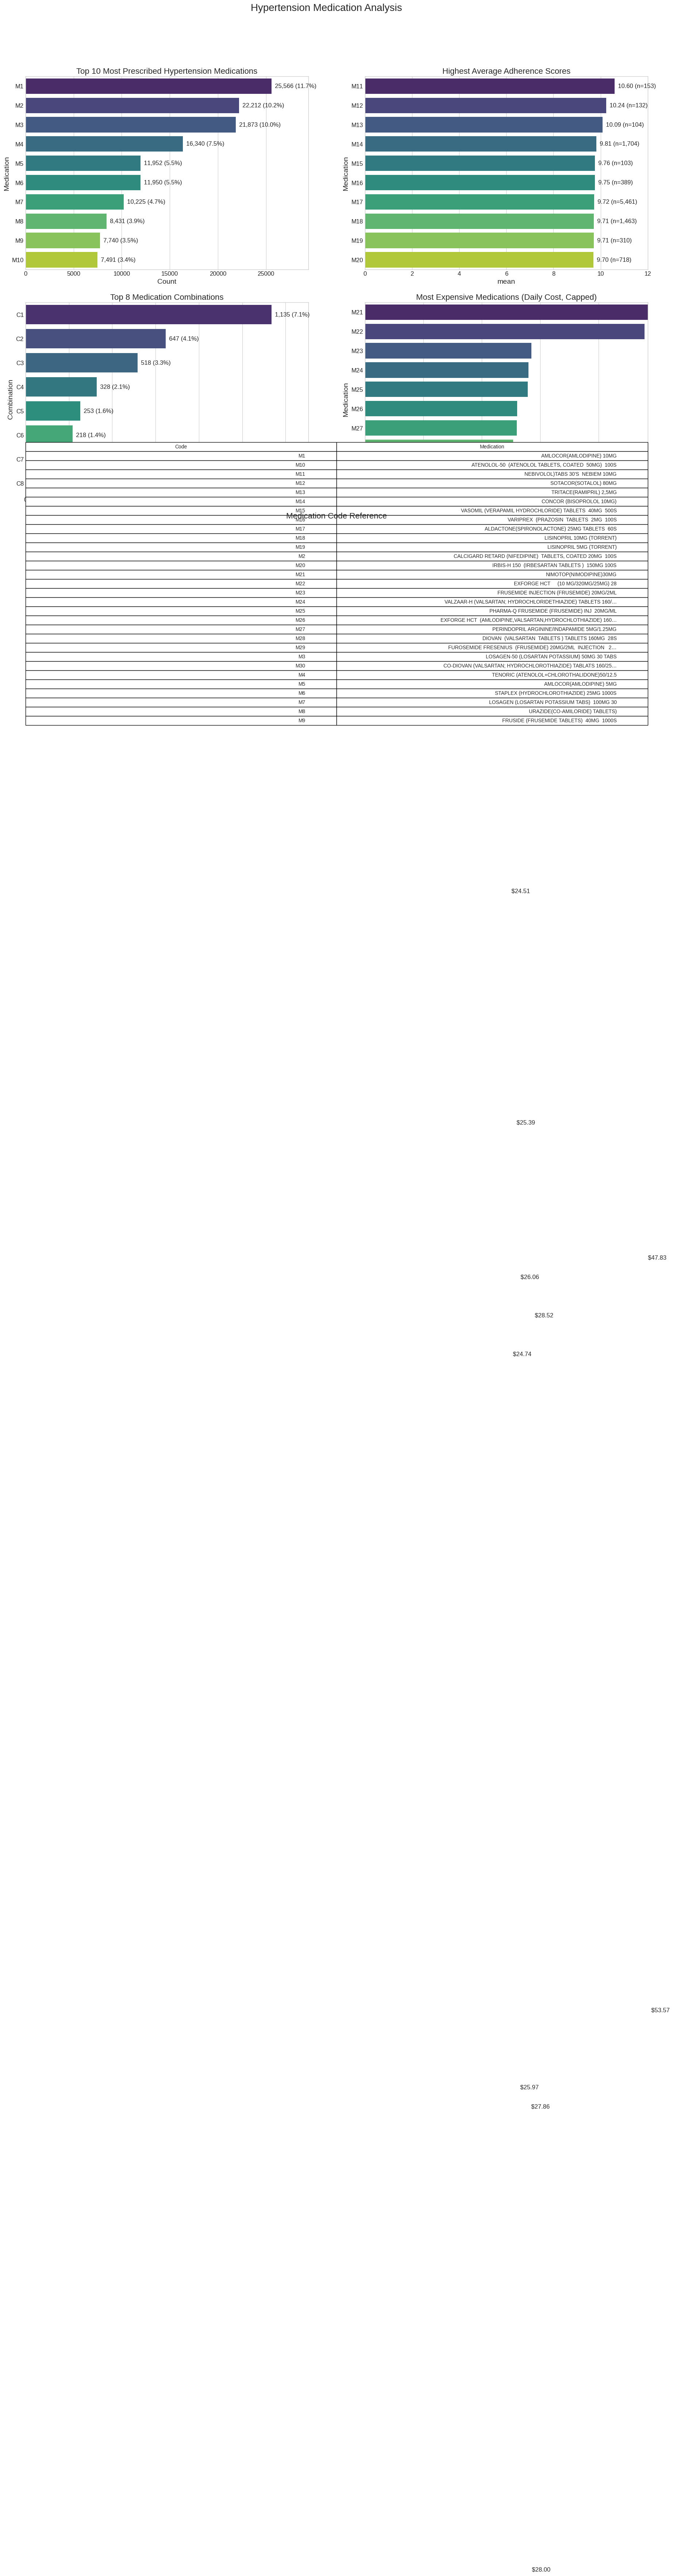

Avg cost vs adherence corr: 0.066
Total cost vs adherence corr: 0.461
Minimal relationship detected.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

def analyze_medications(df, patient_df):
    """As before, but caps the daily‐cost axis at the 90th percentile."""
    def create_med_abbreviations(med_list):
        return {med: f"M{i+1}" for i, med in enumerate(med_list)}

    # FIGURE SETUP
    fig = plt.figure(figsize=(22, 20))
    gs  = fig.add_gridspec(3, 2, height_ratios=[1.4, 1.4, 0.8])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, :])

    # 1) Top 10 prescriptions
    med_counts = df['CODE DESCRIPTION'].value_counts().head(10)
    med_map    = create_med_abbreviations(med_counts.index)
    med_df     = pd.DataFrame({
        'Medication': [med_map[m] for m in med_counts.index],
        'Count'     : med_counts.values
    })
    sns.barplot(y='Medication', x='Count', data=med_df, palette='viridis', ax=ax1)
    ax1.set_title('Top 10 Most Prescribed Hypertension Medications', fontsize=16)
    ax1.set_xlim(0, med_df['Count'].max()*1.15)
    total = len(df)
    for i, cnt in enumerate(med_df['Count']):
        pct = 100 * cnt / total
        ax1.text(cnt, i, f"  {cnt:,} ({pct:.1f}%)", va='center')

    # 2) Top 10 by adherence
    common = df['CODE DESCRIPTION'].value_counts()
    common = common[common >= 100].index
    med_adh = (df[df['CODE DESCRIPTION'].isin(common)]
               .groupby('CODE DESCRIPTION')['ADHERENCE']
               .agg(['mean','count'])
               .sort_values('mean', ascending=False)
               .head(10))
    for m in med_adh.index:
        med_map.setdefault(m, f"M{len(med_map)+1}")
    adh_df = med_adh.reset_index()
    adh_df['Medication'] = adh_df['CODE DESCRIPTION'].map(med_map)
    sns.barplot(y='Medication', x='mean', data=adh_df, palette='viridis', ax=ax2)
    ax2.set_title('Highest Average Adherence Scores', fontsize=16)
    ax2.set_xlim(0, 12)
    for i, row in adh_df.iterrows():
        ax2.text(row['mean'], i, f"  {row['mean']:.2f} (n={row['count']:,})", va='center')

    # 3) Top 8 combinations
    combos = (df.groupby('MEMBER')['CODE DESCRIPTION']
                .apply(lambda x: '; '.join(sorted(set(x))))
                .value_counts()
                .head(8))
    combo_map = {c: f"C{i+1}" for i, c in enumerate(combos.index)}
    combo_df  = pd.DataFrame({
        'Combination': [combo_map[c] for c in combos.index],
        'Count'      : combos.values
    })
    sns.barplot(y='Combination', x='Count', data=combo_df, palette='viridis', ax=ax3)
    ax3.set_title('Top 8 Medication Combinations', fontsize=16)
    ax3.set_xlim(0, combo_df['Count'].max()*1.15)
    tot_pats = df['MEMBER'].nunique()
    for i, cnt in enumerate(combo_df['Count']):
        pct = 100 * cnt / tot_pats
        ax3.text(cnt, i, f"  {cnt:,} ({pct:.1f}%)", va='center')

    # 4) Daily‐cost, capped at 90th percentile
    cost_df = (df.groupby('CODE DESCRIPTION')
                 .agg({'AMOUNT CLAIMED':'mean','UNITS':'mean'})
                 .reset_index())
    cost_df['DAILY_COST'] = cost_df['AMOUNT CLAIMED'] / (cost_df['UNITS']*30)
    expensive = cost_df.sort_values('DAILY_COST', ascending=False).head(10)
    for m in expensive['CODE DESCRIPTION']:
        med_map.setdefault(m, f"M{len(med_map)+1}")
    expensive['Medication'] = expensive['CODE DESCRIPTION'].map(med_map)

    cap = expensive['DAILY_COST'].quantile(0.90)
    sns.barplot(y='Medication', x='DAILY_COST', data=expensive, palette='viridis', ax=ax4)
    ax4.set_title('Most Expensive Medications (Daily Cost, Capped)', fontsize=16)
    ax4.set_xlim(0, cap)
    ax4.set_xlabel(f'Daily Cost ($) — capped at ${cap:,.2f}')
    for i, row in expensive.iterrows():
        x = min(row['DAILY_COST'], cap)
        ax4.text(x, i, f"  ${row['DAILY_COST']:.2f}", va='center')

    # 5) Code reference table
    ax5.axis('off')
    table_data = [[code, (med if len(med)<=60 else med[:57]+'…')]
                  for med, code in sorted(med_map.items(), key=lambda x: x[1])]
    tbl = ax5.table(cellText=table_data, colLabels=['Code','Medication'], loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1, 1.5)
    ax5.set_title('Medication Code Reference', fontsize=16, pad=20)

    plt.tight_layout(rect=[0,0,1,0.96])
    fig.suptitle('Hypertension Medication Analysis', fontsize=20, y=0.98)
    plt.show()

    # Cost vs adherence correlation
    pcm = df.groupby('MEMBER').agg(
        AVG_COST=('AMOUNT CLAIMED','mean'),
        TOTAL_COST=('AMOUNT CLAIMED','sum'),
        ADHERENCE=('ADHERENCE','first')
    ).reset_index()
    corr1 = pcm[['AVG_COST','ADHERENCE']].corr().iloc[0,1]
    corr2 = pcm[['TOTAL_COST','ADHERENCE']].corr().iloc[0,1]
    print(f"Avg cost vs adherence corr: {corr1:.3f}")
    print(f"Total cost vs adherence corr: {corr2:.3f}")
    if abs(corr1)>0.1:
        print(f"Relationship is {'positive' if corr1>0 else 'negative'}.")
    else:
        print("Minimal relationship detected.")

# Example usage:
analyze_medications(df, patient_df)


## 6. Healthcare Plan Analysis

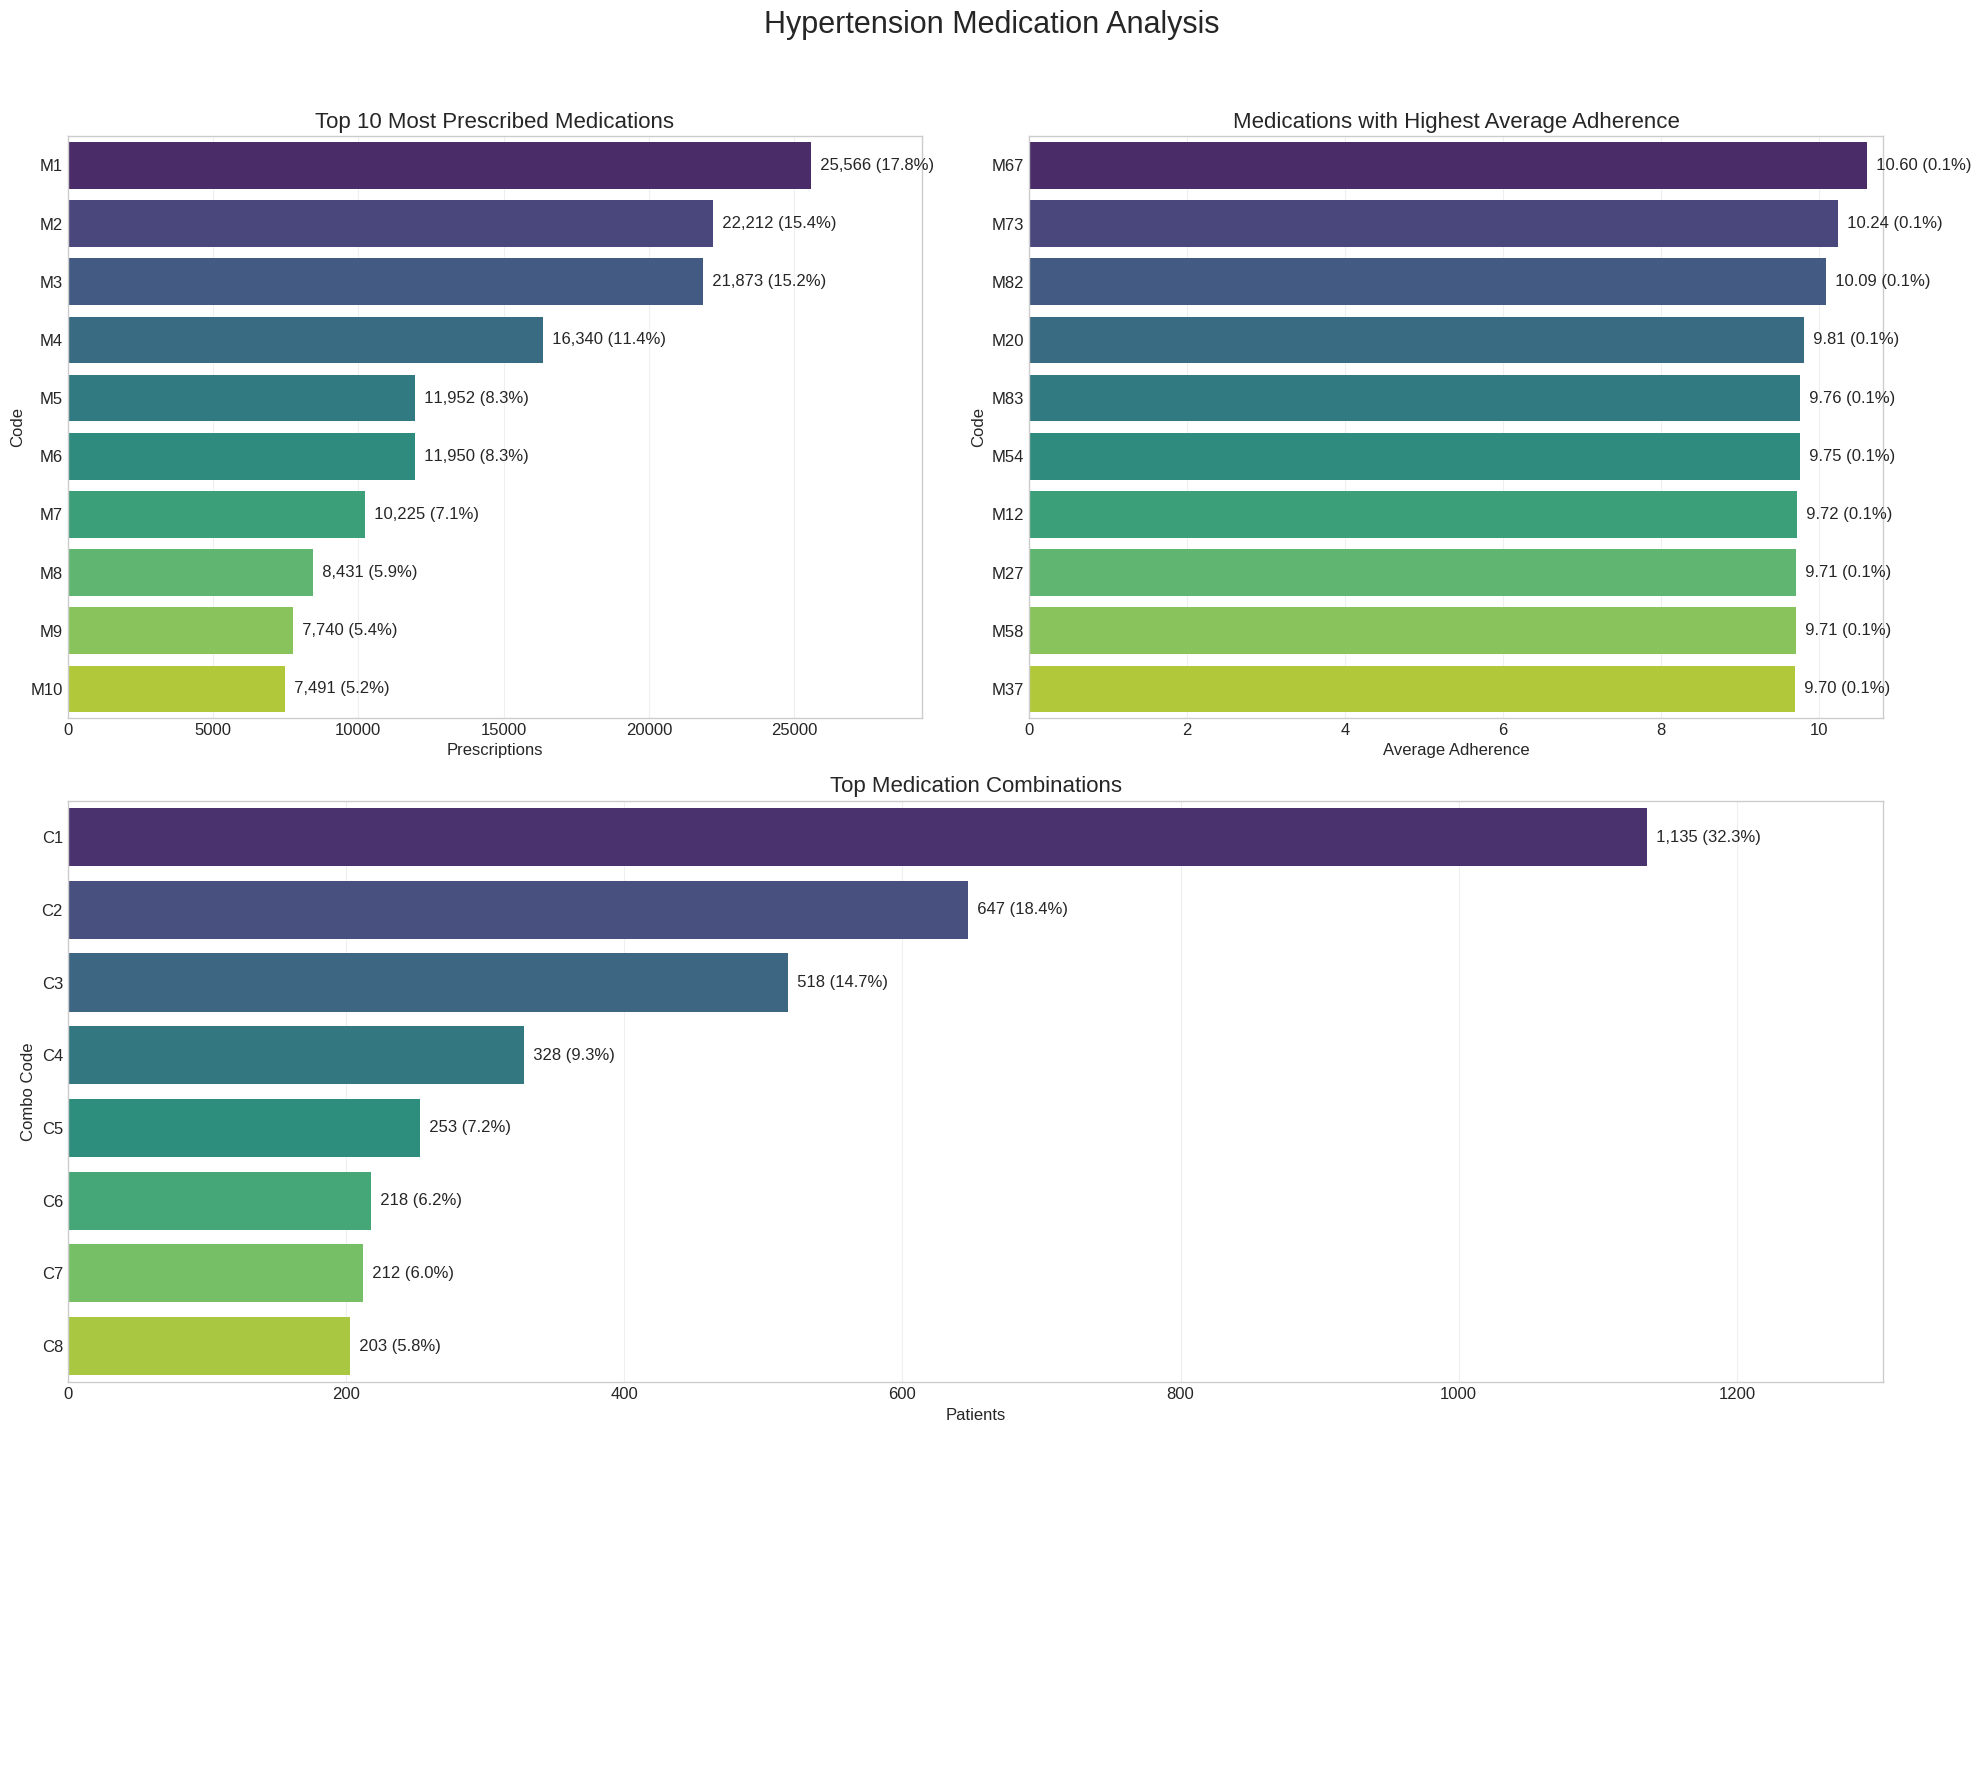

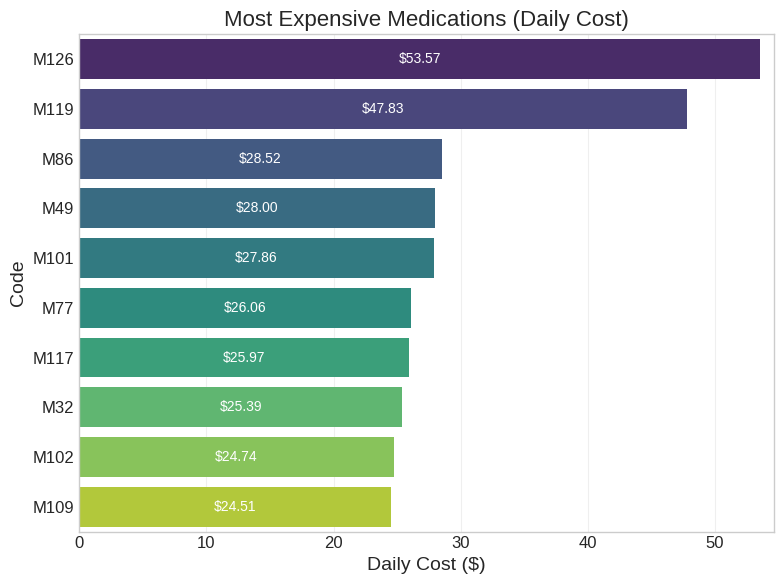

Medication Codes Reference:
                                                                   Code Medication
                                               AMLOCOR(AMLODIPINE) 10MG         M1
                    ATENOLOL-50  (ATENOLOL TABLETS, COATED  50MG)  100S        M10
                                            CARDURA TABLETS (DOXAZOSIN)       M100
                            PHARMA-Q FRUSEMIDE (FRUSEMIDE) INJ  20MG/ML       M101
       FUROSEMIDE FRESENIUS  (FRUSEMIDE) 20MG/2ML  INJECTION   20MG/2ML       M102
                                     ATACAND(CANDESARTAN CILEXETIL) 8MG       M103
                  VASOMIL (VERAPAMIL HYDROCHLORIDE) TABLETS  40MG  100S       M104
                                                CAPOREX(CAPTOPRIL) 25MG       M105
                 ALFUTOR ER (ALFUZOSIN HYDROCHLORIDE)  TABLETS 10MG 30S       M106
                   DYTOR PLUS-10 (TORSEMIDE 10MG  /SPIRONOLACTONE 50MG)       M107
                   ZIAK (BISOPROLOL FUMARATE / HCT TABLETS 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def create_abbreviations(items, prefix="M"):
    """
    Generate a mapping of items to abbreviated codes (e.g., M1, M2, ...).
    """
    return {item: f"{prefix}{i+1}" for i, item in enumerate(items)}


def plot_bar(ax, x, y, title, xlabel, ylabel, annotate=None, fmt="{:.2f}", xlim_margin=0.15, fontsize=12):
    """
    General horizontal bar chart with optional annotations.
    """
    sns.barplot(x=x, y=y, data=annotate if isinstance(annotate, pd.DataFrame) else dict(x=x, y=y), palette='viridis', ax=ax)
    ax.set_title(title, fontsize=fontsize + 4)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.grid(True, axis='x', alpha=0.3)
    max_val = annotate[x.name].max() if isinstance(annotate, pd.DataFrame) else max(x)
    ax.set_xlim(0, max_val * (1 + xlim_margin))

    if annotate is not None:
        for i, val in enumerate(annotate[x.name] if isinstance(annotate, pd.DataFrame) else x):
            label = fmt.format(val) if isinstance(val, float) else f"{val:,}"
            if 'count' in annotate:
                pct = 100 * val / annotate['count'].sum()
                label += f" ({pct:.1f}%)"
            ax.text(val, i, f"  {label}", va='center', fontsize=fontsize)


def plot_top_medications(df, ax, med_map, top_n=10):
    counts = df['CODE DESCRIPTION'].value_counts().head(top_n)
    med_df = pd.DataFrame({
        'Medication': [med_map[m] for m in counts.index],
        'count': counts.values
    })
    med_df['count'] = med_df['count'].astype(int)
    med_df['count'].name = 'count'
    med_df.reset_index(drop=True, inplace=True)
    plot_bar(
        ax, x=med_df['count'], y=med_df['Medication'],
        title='Top 10 Most Prescribed Medications',
        xlabel='Prescriptions', ylabel='Code',
        annotate=med_df
    )


def plot_med_adherence(df, ax, med_map, min_count=100, top_n=10):
    meds = df['CODE DESCRIPTION'].value_counts()
    common = meds[meds >= min_count].index
    adherence = (
        df[df['CODE DESCRIPTION'].isin(common)]
        .groupby('CODE DESCRIPTION')['ADHERENCE']
        .agg(['mean', 'count'])
        .sort_values('mean', ascending=False)
        .head(top_n)
        .reset_index()
    )
    adherence['Medication'] = adherence['CODE DESCRIPTION'].map(med_map)
    adherence.rename(columns={'mean':'avg', 'count':'count'}, inplace=True)
    plot_bar(
        ax, x=adherence['avg'], y=adherence['Medication'],
        title='Medications with Highest Average Adherence',
        xlabel='Average Adherence', ylabel='Code',
        annotate=adherence, fmt="{:.2f}", xlim_margin=0.05
    )
    ax.set_xlim(0, adherence['avg'].max() * 1.02)


def plot_combinations(df, ax, med_map, top_n=8):
    combos = (
        df.groupby('MEMBER')['CODE DESCRIPTION']
          .apply(lambda x: ';'.join(sorted(set(x))))
          .value_counts()
          .head(top_n)
    )
    combo_map = create_abbreviations(combos.index, prefix="C")
    combo_df = pd.DataFrame({
        'Combination': [combo_map[c] for c in combos.index],
        'count': combos.values
    })
    plot_bar(
        ax, x=combo_df['count'], y=combo_df['Combination'],
        title='Top Medication Combinations',
        xlabel='Patients', ylabel='Combo Code',
        annotate=combo_df
    )
    return combo_map


def plot_costs(df, ax, med_map, top_n=10):
    costs = (
        df.groupby('CODE DESCRIPTION')
          .agg({'AMOUNT CLAIMED':'mean','UNITS':'mean'})
          .assign(DAILY_COST=lambda x: x['AMOUNT CLAIMED']/(x['UNITS']*30))
          .reset_index()
          .sort_values('DAILY_COST', ascending=False)
          .head(top_n)
    )
    costs['Medication'] = costs['CODE DESCRIPTION'].map(med_map)
    sns.barplot(x='DAILY_COST', y='Medication', data=costs, palette='viridis', ax=ax)
    ax.set_title('Most Expensive Medications (Daily Cost)', fontsize=16)
    ax.set_xlabel('Daily Cost ($)', fontsize=14)
    ax.set_ylabel('Code', fontsize=14)
    ax.grid(True, axis='x', alpha=0.3)
    max_val = costs['DAILY_COST'].max()
    ax.set_xlim(0, max_val * 1.02)
    for i, val in enumerate(costs['DAILY_COST']):
        ax.text(val/2, i, f"${val:.2f}", ha='center', va='center', fontsize=10, color='white')


def create_reference_table(med_map, combo_map=None):
    med_items = sorted(med_map.items(), key=lambda x: x[1])
    med_table = pd.DataFrame(med_items, columns=['Code','Medication'])
    print("Medication Codes Reference:")
    print(med_table.to_string(index=False))
    if combo_map:
        combo_items = sorted(combo_map.items(), key=lambda x: x[1])
        combo_table = pd.DataFrame(combo_items, columns=['Code','Combination'])
        print("\nCombination Codes Reference:")
        print(combo_table.to_string(index=False))


def analyze_medications(df, patient_df):
    """
    Comprehensive analysis of medication prescribing, adherence, combinations, and cost.
    """
    top_meds = df['CODE DESCRIPTION'].value_counts().index.tolist()
    med_map = create_abbreviations(top_meds)

    # Main composite figure
    fig = plt.figure(figsize=(20, 18))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.5])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])  # spans both columns
    ax4 = fig.add_subplot(gs[2, :])  # reserved for table reference printed below
    ax4.axis('off')

    plot_top_medications(df, ax1, med_map)
    plot_med_adherence(df, ax2, med_map)
    combo_map = plot_combinations(df, ax3, med_map)

    fig.suptitle('Hypertension Medication Analysis', fontsize=22)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Separate cost figure
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_costs(df, ax, med_map)
    plt.tight_layout()
    plt.show()
    # Print reference table
    create_reference_table(med_map, combo_map)


    # Correlation analysis
    costs = (
        df.groupby('MEMBER')
          .agg(AVG_COST_PER_RX=('AMOUNT CLAIMED','mean'),
               TOTAL_COST=('AMOUNT CLAIMED','sum'),
               ADHERENCE=('ADHERENCE','first'))
          .reset_index()
    )
    corr_avg = costs['AVG_COST_PER_RX'].corr(costs['ADHERENCE'])
    corr_tot = costs['TOTAL_COST'].corr(costs['ADHERENCE'])
    print(f"Correlation (Avg Cost vs Adherence): {corr_avg:.3f}")
    print(f"Correlation (Total Cost vs Adherence): {corr_tot:.3f}")

analyze_medications(df, patient_df)


## 7. Temporal patterns Analysis

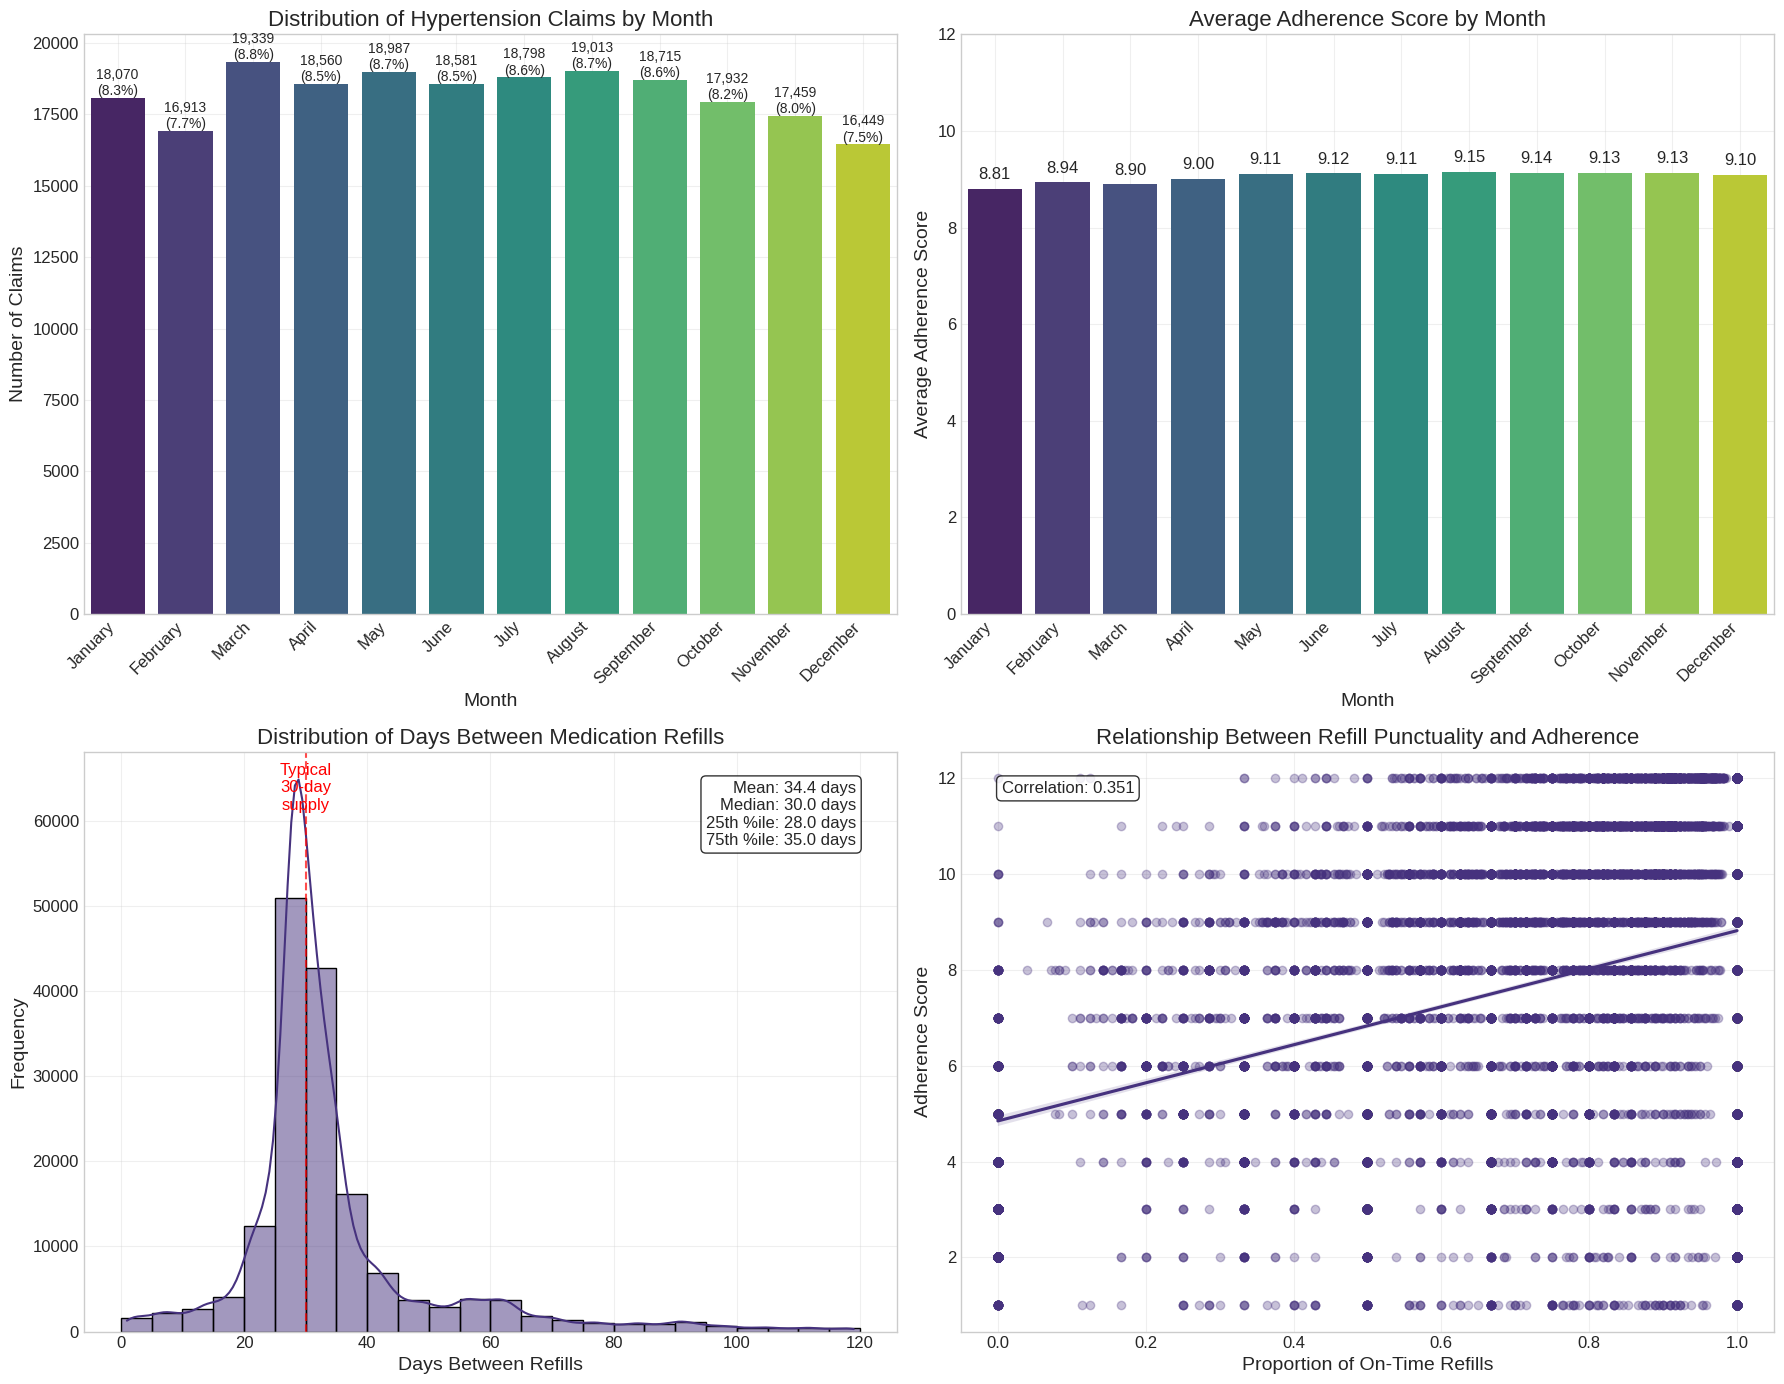

Temporal Pattern Analysis:
• Average interval between refills: 34.4 days (median: 30.0)
• Correlation between on-time refills and adherence: 0.351
• Month with highest adherence: August (score: 9.15)
• Month with lowest adherence: January (score: 8.81)

Seasonal Adherence Patterns:
• Winter (Dec-Feb): 8.94
• Spring (Mar-May): 9.00
• Summer (Jun-Aug): 9.13
• Fall (Sep-Nov): 9.13


In [ ]:
def analyze_temporal_patterns(df, patient_df):
    """
    Analyze temporal patterns in medication claims and refills.

    Parameters:
    -----------
    df : pandas DataFrame
        Original transaction-level data
    patient_df : pandas DataFrame
        Patient-level aggregated data
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Plot 1: Claims by month
    df['Month'] = df['SERVICE DATE'].dt.month_name()
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
    month_counts = df['Month'].value_counts().reindex(month_order)

    sns.barplot(x=month_counts.index, y=month_counts.values, palette='viridis', ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Hypertension Claims by Month', fontsize=16)
    axes[0, 0].set_xlabel('Month', fontsize=14)
    axes[0, 0].set_ylabel('Number of Claims', fontsize=14)
    axes[0, 0].set_xticklabels(month_counts.index, rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3)

    # Add count and percentage labels
    total_claims = month_counts.sum()
    for i, (month, count) in enumerate(month_counts.items()):
        percentage = 100 * count / total_claims
        axes[0, 0].text(i, count + 100, f"{count:,}\n({percentage:.1f}%)",
                      ha='center', fontsize=10)

    # Plot 2: Adherence by month
    monthly_adherence = df.groupby('Month')['ADHERENCE'].mean().reindex(month_order)

    sns.barplot(x=monthly_adherence.index, y=monthly_adherence.values,
               palette='viridis', ax=axes[0, 1])
    axes[0, 1].set_title('Average Adherence Score by Month', fontsize=16)
    axes[0, 1].set_xlabel('Month', fontsize=14)
    axes[0, 1].set_ylabel('Average Adherence Score', fontsize=14)
    axes[0, 1].set_xticklabels(monthly_adherence.index, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 12)

    # Add score labels
    for i, (month, score) in enumerate(monthly_adherence.items()):
        axes[0, 1].text(i, score + 0.2, f"{score:.2f}", ha='center', fontsize=12)

    # Plot 3: Refill intervals analysis
    # Calculate days between refills
    refill_data = df.sort_values(['MEMBER', 'SERVICE DATE'])
    refill_data['Next_Date'] = refill_data.groupby(['MEMBER', 'CODE DESCRIPTION'])['SERVICE DATE'].shift(-1)
    refill_data['Days_Between_Refills'] = (refill_data['Next_Date'] - refill_data['SERVICE DATE']).dt.days

    # Filter out invalid intervals (e.g., negative or extremely large values)
    valid_intervals = refill_data[(refill_data['Days_Between_Refills'] > 0) &
                                 (refill_data['Days_Between_Refills'] < 120)]

    sns.histplot(valid_intervals['Days_Between_Refills'], bins=range(0, 121, 5),
                kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Days Between Medication Refills', fontsize=16)
    axes[1, 0].set_xlabel('Days Between Refills', fontsize=14)
    axes[1, 0].set_ylabel('Frequency', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)

    # Add vertical line at 30 days (typical monthly prescription)
    axes[1, 0].axvline(x=30, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].text(30, axes[1, 0].get_ylim()[1]*0.9, 'Typical\n30-day\nsupply',
                  color='red', ha='center')

    # Calculate refill interval statistics
    refill_stats = valid_intervals['Days_Between_Refills'].describe()
    stats_text = (
        f"Mean: {refill_stats['mean']:.1f} days\n"
        f"Median: {refill_stats['50%']:.1f} days\n"
        f"25th %ile: {refill_stats['25%']:.1f} days\n"
        f"75th %ile: {refill_stats['75%']:.1f} days"
    )
    axes[1, 0].text(0.95, 0.95, stats_text, transform=axes[1, 0].transAxes,
                  fontsize=12, verticalalignment='top', horizontalalignment='right',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plot 4: Refill punctuality vs adherence
    # Define "on-time" refills (e.g., within 7 days of expected date)
    valid_intervals['On_Time'] = (valid_intervals['Days_Between_Refills'] <= 37)  # 30 days + 7 days grace
    on_time_adherence = valid_intervals.groupby('MEMBER')['On_Time'].mean().reset_index()
    on_time_adherence = on_time_adherence.merge(patient_df[['MEMBER', 'ADHERENCE']], on='MEMBER')

    sns.regplot(x='On_Time', y='ADHERENCE', data=on_time_adherence,
               scatter_kws={'alpha': 0.3}, ax=axes[1, 1])
    axes[1, 1].set_title('Relationship Between Refill Punctuality and Adherence', fontsize=16)
    axes[1, 1].set_xlabel('Proportion of On-Time Refills', fontsize=14)
    axes[1, 1].set_ylabel('Adherence Score', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)

    # Calculate correlation
    refill_adh_corr = on_time_adherence[['On_Time', 'ADHERENCE']].corr().iloc[0, 1]

    # Add correlation annotation
    axes[1, 1].text(0.05, 0.95, f"Correlation: {refill_adh_corr:.3f}",
                  transform=axes[1, 1].transAxes,
                  fontsize=12, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Additional temporal analysis
    print("Temporal Pattern Analysis:")
    print(f"• Average interval between refills: {refill_stats['mean']:.1f} days (median: {refill_stats['50%']:.1f})")
    print(f"• Correlation between on-time refills and adherence: {refill_adh_corr:.3f}")

    # Calculate variation by month
    monthly_variation = df.groupby('Month')['ADHERENCE'].agg(['mean', 'std']).reindex(month_order)
    highest_month = monthly_variation['mean'].idxmax()
    lowest_month = monthly_variation['mean'].idxmin()

    print(f"• Month with highest adherence: {highest_month} (score: {monthly_variation.loc[highest_month, 'mean']:.2f})")
    print(f"• Month with lowest adherence: {lowest_month} (score: {monthly_variation.loc[lowest_month, 'mean']:.2f})")

    # Seasonality check
    winter_months = ['December', 'January', 'February']
    spring_months = ['March', 'April', 'May']
    summer_months = ['June', 'July', 'August']
    fall_months = ['September', 'October', 'November']

    winter_adherence = df[df['Month'].isin(winter_months)]['ADHERENCE'].mean()
    spring_adherence = df[df['Month'].isin(spring_months)]['ADHERENCE'].mean()
    summer_adherence = df[df['Month'].isin(summer_months)]['ADHERENCE'].mean()
    fall_adherence = df[df['Month'].isin(fall_months)]['ADHERENCE'].mean()

    print("\nSeasonal Adherence Patterns:")
    print(f"• Winter (Dec-Feb): {winter_adherence:.2f}")
    print(f"• Spring (Mar-May): {spring_adherence:.2f}")
    print(f"• Summer (Jun-Aug): {summer_adherence:.2f}")
    print(f"• Fall (Sep-Nov): {fall_adherence:.2f}")

# Execute temporal patterns analysis
analyze_temporal_patterns(df, patient_df)

## 8. Predictive Factors Analysis

Original data: 15912 rows, After removing missing values: 15912 rows

Multicollinearity Check (VIF > 5 may indicate problems):
                    Variable        VIF
0                      const  18.693101
1                CURRENT_AGE   1.140300
2              TOTAL_CLAIMED   2.020503
3                VISIT_COUNT   3.566407
4                UNIQUE_MEDS   2.000783
5  OBSERVATION_PERIOD_MONTHS   1.759815
6                GENDER_MALE   1.011626

Multiple Regression Analysis: Predictors of Adherence
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.0284      0.064     16.041      0.000       0.903       1.154
CURRENT_AGE                   0.0108      0.001      9.944      0.000       0.009       0.013
TOTAL_CLAIMED              7.465e-07    2.1e-07      3.549      0.000    3.34e-07    1.16e-06
VISIT_COUNT                 

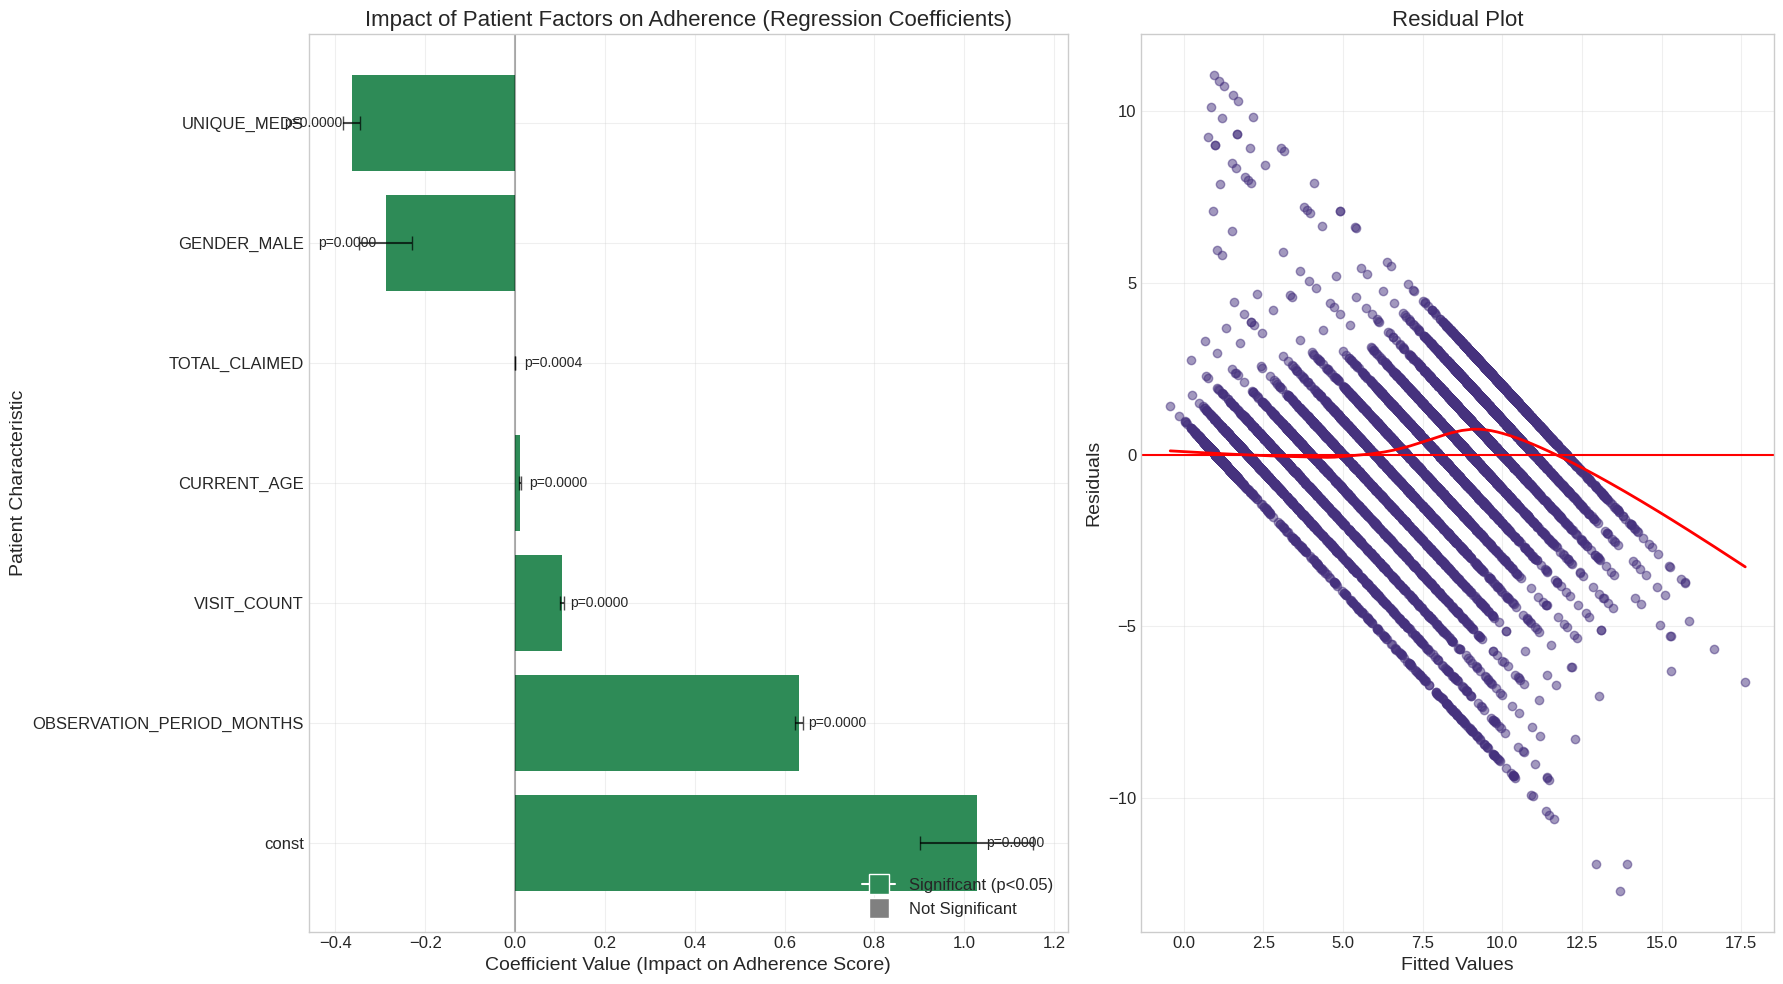

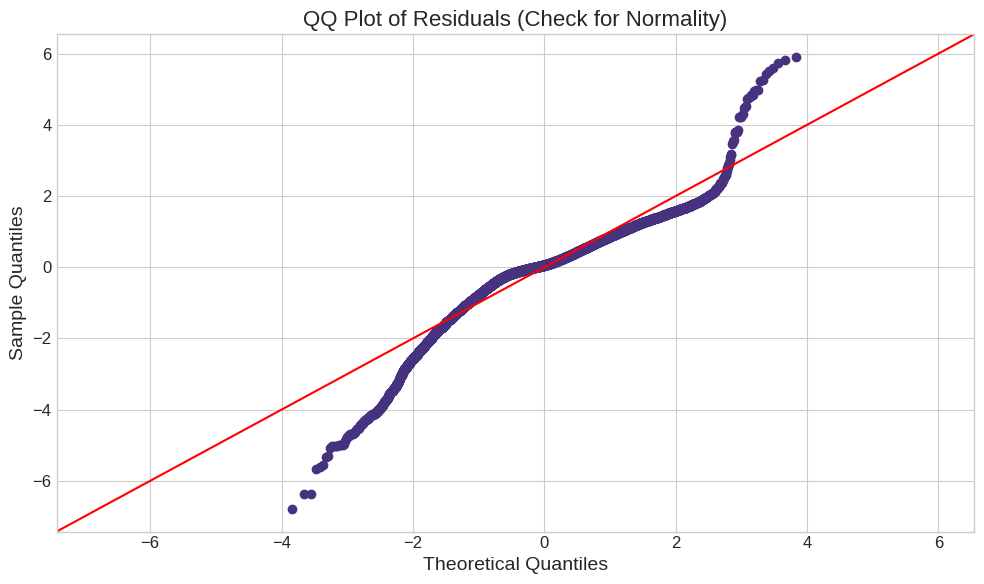


Key Predictors of Adherence:
• Factors associated with HIGHER adherence:
  - Observation Period Months (Std. Effect: 0.697)
  - Visit Count (Std. Effect: 0.335)
  - Current Age (Std. Effect: 0.040)
  - Total Claimed (Std. Effect: 0.019)

• Factors associated with LOWER adherence:
  - Gender Male (Std. Effect: -0.036)
  - Unique Meds (Std. Effect: -0.199)

• Model R-squared: 0.775 (Adjusted: 0.775)
• This means 77.5% of variation in adherence is explained by these factors

Model Diagnostics Summary:
• Durbin-Watson (autocorrelation check, ~2 is good): 2.013
• Heteroscedasticity (Breusch-Pagan): p=0.0000 (Present)
• Normality of Residuals (Jarque-Bera): p=0.0000 (Non-normal)


In [ ]:
def analyze_predictive_factors(patient_df):
    """
    Analyze factors that predict medication adherence with enhanced diagnostics
    and visualization.

    Parameters:
    -----------
    patient_df : pandas DataFrame
        Patient-level aggregated data
    """
    # Select numeric features for regression
    features = ['CURRENT_AGE', 'TOTAL_CLAIMED', 'VISIT_COUNT', 'UNIQUE_MEDS',
               'OBSERVATION_PERIOD_MONTHS']

    # Add gender as dummy variable
    patient_model = patient_df.copy()
    patient_model['GENDER_MALE'] = (patient_model['GENDER'] == 'M').astype(int)
    features.append('GENDER_MALE')

    # Handle missing data
    model_data = patient_model[features + ['ADHERENCE']].dropna()
    print(f"Original data: {len(patient_model)} rows, After removing missing values: {len(model_data)} rows")

    # Create feature matrix with constant term
    X = sm.add_constant(model_data[features])
    y = model_data['ADHERENCE']

    # Check for multicollinearity
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nMulticollinearity Check (VIF > 5 may indicate problems):")
    print(vif_data)

    # Fit multiple regression model
    model = sm.OLS(y, X).fit()

    # Print summary statistics
    print("\nMultiple Regression Analysis: Predictors of Adherence")
    print("="*80)
    print(model.summary().tables[1])
    print("="*80)

    # Extract and sort coefficients
    coef_df = pd.DataFrame({
        'Variable': model.params.index,
        'Coefficient': model.params.values,
        'Std Error': model.bse,
        'P-Value': model.pvalues,
        'Significant': model.pvalues < 0.05
    }).sort_values('Coefficient', ascending=False)

    # Create two subplots: one for coefficients, one for diagnostic plots
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1])

    # First subplot: coefficient plot
    ax1 = fig.add_subplot(gs[0])

    # Plot coefficients
    colors = ['seagreen' if sig else 'gray' for sig in coef_df['Significant']]
    bars = ax1.barh(coef_df['Variable'], coef_df['Coefficient'], color=colors)

    # Add error bars
    for i, (_, row) in enumerate(coef_df.iterrows()):
        ax1.errorbar(row['Coefficient'], i, xerr=row['Std Error']*1.96,
                    fmt='none', color='black', capsize=5, alpha=0.7)

    # Add zero line
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    # Formatting
    ax1.set_title('Impact of Patient Factors on Adherence (Regression Coefficients)', fontsize=16)
    ax1.set_xlabel('Coefficient Value (Impact on Adherence Score)', fontsize=14)
    ax1.set_ylabel('Patient Characteristic', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Add p-value annotations
    for i, (_, row) in enumerate(coef_df.iterrows()):
        p_val_text = f"p={row['P-Value']:.4f}" if row['P-Value'] < 0.05 else "n.s."
        ax1.text(row['Coefficient'] + 0.02 if row['Coefficient'] > 0 else row['Coefficient'] - 0.15,
                i, p_val_text, va='center', fontsize=10)

    # Add legend for significance
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', markerfacecolor='seagreen',
              markersize=15, label='Significant (p<0.05)'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray',
              markersize=15, label='Not Significant')
    ]
    ax1.legend(handles=legend_elements, loc='lower right')

    # Second subplot: diagnostic plots
    ax2 = fig.add_subplot(gs[1])

    # Residual plot
    residuals = model.resid
    fitted_values = model.fittedvalues

    ax2.scatter(fitted_values, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='-')
    ax2.set_title('Residual Plot', fontsize=16)
    ax2.set_xlabel('Fitted Values', fontsize=14)
    ax2.set_ylabel('Residuals', fontsize=14)
    ax2.grid(True, alpha=0.3)

    # Add lowess trend line to check linearity
    from statsmodels.nonparametric.smoothers_lowess import lowess
    lowess_results = lowess(residuals, fitted_values, frac=0.6)
    ax2.plot(lowess_results[:, 0], lowess_results[:, 1], 'r-', linewidth=2)

    plt.tight_layout()
    plt.show()

    # QQ plot for normality check
    fig, ax = plt.subplots(figsize=(10, 6))
    from statsmodels.graphics.gofplots import qqplot
    qqplot(residuals, line='45', fit=True, ax=ax)
    ax.set_title('QQ Plot of Residuals (Check for Normality)', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Interpretation
    print("\nKey Predictors of Adherence:")

    sig_positive = coef_df[(coef_df['Significant']) & (coef_df['Coefficient'] > 0)]['Variable'].tolist()
    sig_negative = coef_df[(coef_df['Significant']) & (coef_df['Coefficient'] < 0)]['Variable'].tolist()

    if sig_positive:
        print("• Factors associated with HIGHER adherence:")
        for factor in sig_positive:
            if factor != 'const':  # Skip intercept
                # Get the standardized effect size
                factor_idx = list(X.columns).index(factor)
                effect = model.params[factor_idx] * X[factor].std() / y.std()
                print(f"  - {factor.replace('_', ' ').title()} (Std. Effect: {effect:.3f})")

    if sig_negative:
        print("\n• Factors associated with LOWER adherence:")
        for factor in sig_negative:
            if factor != 'const':  # Skip intercept
                factor_idx = list(X.columns).index(factor)
                effect = model.params[factor_idx] * X[factor].std() / y.std()
                print(f"  - {factor.replace('_', ' ').title()} (Std. Effect: {effect:.3f})")

    print(f"\n• Model R-squared: {model.rsquared:.3f} (Adjusted: {model.rsquared_adj:.3f})")
    print(f"• This means {model.rsquared*100:.1f}% of variation in adherence is explained by these factors")

    # Model diagnostics summary
    print("\nModel Diagnostics Summary:")
    print(f"• Durbin-Watson (autocorrelation check, ~2 is good): {sm.stats.stattools.durbin_watson(residuals):.3f}")

    # Breusch-Pagan test for heteroscedasticity
    from statsmodels.stats.diagnostic import het_breuschpagan
    bp_test = het_breuschpagan(residuals, X)
    print(f"• Heteroscedasticity (Breusch-Pagan): p={bp_test[1]:.4f} ({'Present' if bp_test[1]<0.05 else 'Not detected'})")

    # Jarque-Bera test for normality
    from scipy import stats
    jb_test = stats.jarque_bera(residuals)
    print(f"• Normality of Residuals (Jarque-Bera): p={jb_test[1]:.4f} ({'Non-normal' if jb_test[1]<0.05 else 'Normal'})")

    return model  # Return the model for further analysis if needed

# Execute predictive factors analysis
model = analyze_predictive_factors(patient_df)


# 9. Recommendations and Conclusions

In [ ]:
def generate_recommendations(df, patient_df):
    """
    Generate data-driven recommendations based on analysis results.

    Parameters:
    -----------
    df : pandas DataFrame
        Original transaction-level data
    patient_df : pandas DataFrame
        Patient-level aggregated data
    """
    print("========== SUMMARY OF KEY FINDINGS ==========")
    print("\n1. DEMOGRAPHIC INSIGHTS:")

    # Age insights
    age_adherence_corr = patient_df[['CURRENT_AGE', 'ADHERENCE']].corr().iloc[0, 1]
    print(f"• Age correlation with adherence: {age_adherence_corr:.3f}")
    oldest_group = patient_df.groupby('AGE_GROUP')['ADHERENCE'].mean().idxmax()
    youngest_group = patient_df.groupby('AGE_GROUP')['ADHERENCE'].mean().idxmin()
    print(f"• Highest adherence age group: {oldest_group}")
    print(f"• Lowest adherence age group: {youngest_group}")

    # Gender insights
    males = patient_df[patient_df['GENDER'] == 'M']['ADHERENCE']
    females = patient_df[patient_df['GENDER'] == 'F']['ADHERENCE']
    t_stat, p_value = stats.ttest_ind(males, females, equal_var=False)

    if p_value < 0.05:
        better_gender = "males" if males.mean() > females.mean() else "females"
        print(f"• Significant gender difference: {better_gender} show better adherence (p={p_value:.3f})")
    else:
        print(f"• No significant gender differences in adherence (p={p_value:.3f})")

    print("\n2. ADHERENCE PATTERNS:")
    adherence_mean = patient_df['ADHERENCE'].mean()
    adherence_med = patient_df['ADHERENCE'].median()

    print(f"• Average adherence score: {adherence_mean:.2f}/12")
    print(f"• Median adherence score: {adherence_med:.1f}/12")

    # Adherence categories
    low_pct = 100 * (patient_df['ADHERENCE'] <= 4).mean()
    med_pct = 100 * ((patient_df['ADHERENCE'] > 4) & (patient_df['ADHERENCE'] <= 8)).mean()
    high_pct = 100 * (patient_df['ADHERENCE'] > 8).mean()

    print(f"• Low adherence (1-4): {low_pct:.1f}% of patients")
    print(f"• Medium adherence (5-8): {med_pct:.1f}% of patients")
    print(f"• High adherence (9-12): {high_pct:.1f}% of patients")

    print("\n3. MEDICATION INSIGHTS:")
    # Top medication
    top_med = df['CODE DESCRIPTION'].value_counts().idxmax()
    top_med_pct = 100 * df['CODE DESCRIPTION'].value_counts().max() / len(df)
    print(f"• Most common medication: {top_med} ({top_med_pct:.1f}% of prescriptions)")

    # Best adherence medication (with sufficient sample)
    common_meds = df['CODE DESCRIPTION'].value_counts()
    common_meds = common_meds[common_meds >= 100].index
    med_adherence = df[df['CODE DESCRIPTION'].isin(common_meds)].groupby('CODE DESCRIPTION')['ADHERENCE'].mean()
    best_med = med_adherence.idxmax()
    worst_med = med_adherence.idxmin()

    print(f"• Medication with highest adherence: {best_med} (score: {med_adherence.max():.2f})")
    print(f"• Medication with lowest adherence: {worst_med} (score: {med_adherence.min():.2f})")

    print("\n4. HEALTHCARE PLAN INSIGHTS:")
    # Plan with best adherence (minimum 30 patients)
    plan_adherence = patient_df.groupby('HEALTHCARE_PLAN')['ADHERENCE'].agg(['mean', 'count'])
    plan_adherence = plan_adherence[plan_adherence['count'] >= 30]
    best_plan = plan_adherence.sort_values('mean', ascending=False).index[0]
    worst_plan = plan_adherence.sort_values('mean', ascending=True).index[0]

    print(f"• Healthcare plan with highest adherence: {best_plan} (score: {plan_adherence.loc[best_plan, 'mean']:.2f})")
    print(f"• Healthcare plan with lowest adherence: {worst_plan} (score: {plan_adherence.loc[worst_plan, 'mean']:.2f})")

    print("\n5. TEMPORAL INSIGHTS:")
    # Refill patterns
    refill_data = df.sort_values(['MEMBER', 'SERVICE DATE'])
    refill_data['Next_Date'] = refill_data.groupby(['MEMBER', 'CODE DESCRIPTION'])['SERVICE DATE'].shift(-1)
    refill_data['Days_Between_Refills'] = (refill_data['Next_Date'] - refill_data['SERVICE DATE']).dt.days
    valid_intervals = refill_data[(refill_data['Days_Between_Refills'] > 0) & (refill_data['Days_Between_Refills'] < 120)]

    refill_median = valid_intervals['Days_Between_Refills'].median()
    print(f"• Median days between refills: {refill_median:.1f}")

    # On-time refill correlation
    valid_intervals['On_Time'] = (valid_intervals['Days_Between_Refills'] <= 37)
    on_time_adherence = valid_intervals.groupby('MEMBER')['On_Time'].mean().reset_index()
    on_time_adherence = on_time_adherence.merge(patient_df[['MEMBER', 'ADHERENCE']], on='MEMBER')
    refill_adh_corr = on_time_adherence[['On_Time', 'ADHERENCE']].corr().iloc[0, 1]

    print(f"• Correlation between on-time refills and adherence: {refill_adh_corr:.3f}")

    print("\n========== RECOMMENDATIONS ==========")

    # Age-based recommendations
    print("\n1. AGE-TARGETED INTERVENTIONS:")
    if age_adherence_corr > 0.1:
        print(f"• Focus adherence improvement efforts on younger patients (<50 years)")
        print("• Develop age-specific education materials addressing unique barriers faced by younger patients")
        print("• Consider digital reminders and mobile apps for younger patients")
    elif age_adherence_corr < -0.1:
        print(f"• Focus adherence improvement efforts on older patients (>60 years)")
        print("• Address potential barriers like polypharmacy, physical limitations, and cognitive issues")
        print("• Consider simplified medication regimens and pill organizers")
    else:
        print("• Age appears to be a weak predictor; focus on other factors")

    # Refill-based recommendations
    print("\n2. REFILL OPTIMIZATION:")
    print("• Implement automated refill reminder systems")
    if refill_median < 28:
        print("• Investigate potential stockpiling behavior")
    elif refill_median > 32:
        print("• Address potential gaps in medication coverage")

    print(f"• Target patients with irregular refill patterns for intervention")
    print("• Consider 90-day supply options for stable patients to reduce refill frequency")

    # Medication recommendations
    print("\n3. MEDICATION STRATEGIES:")
    print(f"• When clinically appropriate, consider preferential prescribing of medications with better adherence")
    print("• Review medication combinations for simplification opportunities")
    print("• Investigate reasons for lower adherence with certain medications (side effects, cost, etc.)")

    # Healthcare plan recommendations
    print("\n4. HEALTHCARE PLAN IMPROVEMENTS:")
    print(f"• Study features of high-performing plans like {best_plan} for potential adoption")
    print("• Consider adherence incentives within healthcare plans")
    print("• Improve medication coverage to reduce out-of-pocket costs")

    # General recommendations
    print("\n5. COMPREHENSIVE APPROACH:")
    print("• Develop a risk stratification model to identify patients at high risk for non-adherence")
    print("• Implement multi-faceted interventions including education, reminders, and behavioral support")
    print("• Provide regular feedback to healthcare providers about patient adherence patterns")
    print("• Consider seasonal programs to address adherence variation throughout the year")

# Generate comprehensive recommendations
generate_recommendations(df, patient_df)

========== SUMMARY OF KEY FINDINGS ==========

1. DEMOGRAPHIC INSIGHTS:
• Age correlation with adherence: 0.314
• Highest adherence age group: 71-80
• Lowest adherence age group: 20-30
• Significant gender difference: females show better adherence (p=0.022)

2. ADHERENCE PATTERNS:
• Average adherence score: 6.43/12
• Median adherence score: 7.0/12
• Low adherence (1-4): 37.4% of patients
• Medium adherence (5-8): 23.5% of patients
• High adherence (9-12): 39.1% of patients

3. MEDICATION INSIGHTS:
• Most common medication: AMLOCOR(AMLODIPINE) 10MG (11.7% of prescriptions)
• Medication with highest adherence: NEBIVOLOL)TABS 30'S  NEBIEM 10MG (score: 10.60)
• Medication with lowest adherence: HYPOTENS (METHYLDOPA) TABLETS (score: 6.20)

4. HEALTHCARE PLAN INSIGHTS:
• Healthcare plan with highest adherence: MEDEXEC (score: 7.94)
• Healthcare plan with lowest adherence: PRIVATE LITE (score: 1.94)

5. TEMPORAL INSIGHTS:
• Median days between refills: 30.0
• Correlation between on-time refil

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
import os

# Create output directory if it doesn't exist
output_dir = "medication_tables"
os.makedirs(output_dir, exist_ok=True)

# Raw data strings
raw_med = """
AMLOCOR(AMLODIPINE) 10MG         M1
ATENOLOL-50  (ATENOLOL TABLETS, COATED  50MG)  100S        M10
CARDURA TABLETS (DOXAZOSIN)       M100
PHARMA-Q FRUSEMIDE (FRUSEMIDE) INJ  20MG/ML       M101
FUROSEMIDE FRESENIUS  (FRUSEMIDE) 20MG/2ML  INJECTION   20MG/2ML       M102
ATACAND(CANDESARTAN CILEXETIL) 8MG       M103
VASOMIL (VERAPAMIL HYDROCHLORIDE) TABLETS  40MG  100S       M104
CAPOREX(CAPTOPRIL) 25MG       M105
ALFUTOR ER (ALFUZOSIN HYDROCHLORIDE)  TABLETS 10MG 30S       M106
DYTOR PLUS-10 (TORSEMIDE 10MG  /SPIRONOLACTONE 50MG)       M107
ZIAK (BISOPROLOL FUMARATE / HCT TABLETS 5/6.25MG 30S       M108
CO-DIOVAN (VALSARTAN; HYDROCHLOROTHIAZIDE) TABLATS 160/25MG 28S       M109
EXFORGE (AMLODIPINE + VALSARTAN) TABS 10/160MG 28 TABS        M11
DILTIAZEM   180MG TAB TILOMED UK       M110
PERINDOPRIL -INDAPAMIDE  4MG/1.25MG 30S       M111
DILTIAZEM TABLETS (TORRENT)       M112
HYPOTONE TABS. (METHYLDOPA) 250MG       M113
LISINOPRIL 5MG (ZESTRIL)  TABLETS       M114
DILTIAZEN TABLETS (DILTIAZEM)       M115
ATACAND(CANDESARTAN CILEXETIL) 16MG       M116
PERINDOPRIL ARGININE/INDAPAMIDE 5MG/1.25MG       M117
ZIAK (BISOPROLOL FUMARATE / HCT  TABLETS 10/6.25MG 30S       M118
EXFORGE HCT     (10 MG/320MG/25MG) 28       M119
ALDACTONE(SPIRONOLACTONE) 25MG TABLETS  60S        M12
TRITACE(RAMIPRIL) 10MG       M120
HYPOTONE TABS (METHYLDOPA)       M121
DILTIAZEM TABLETS  240MG  30S       M122
METHYLDOPA TABLETS (GRANCHEM) 250MG       M123
HYPOTENS TABLETS (CAPS)       M124
ACCUMAX CO (QUINAPRIL HYDROCHLORIDE AND HCT TABLETS 20/12,5MG       M125
NIMOTOP(NIMODIPINE)30MG       M126
ACCUMAX CO ( QUINAPRIL /HYDROCHLOROTHIAZIDE TABLETS)  10/12,5MG       M127
LOSAR - 25 (LOSARTAN POTASSIUM) 25MG        M13
CARDURA(DOXAZOSIN MESYLATE) XL 4MG 30S        M14
CONCOR (BISOPROLOL 5MG)        M15
ATENOLOL 100 (ATENOLOL TABLETS, COATED 100MG) 100S        M16
EXFORGE (AMLODIPINE + VALSARTAN) TABS 5/160MG 28 TABS        M17
HYDROCHLOROTHIAZIDE TABLETS        M18
PRESARTAN-50 (LOSARTAN POTASSIUM) TABLETS  50MG        M19
CALCIGARD RETARD (NIFEDIPINE)  TABLETS, COATED 20MG  100S         M2
CONCOR (BISOPROLOL 10MG)        M20
LOSAR*-50 (LOSARTAN POTASIUM TABLETS)  50MG        M21
HYDROCHLOROTHIAZIDE TABLETS (VARICHEM)        M22
EXFORGE (AMLODIPINE +VALSARTAN) TABS 5/80MG        M23
CARDICOR (BISOPOLOL) 5MG        M24
NORVASC(AMLODIPINE) 5MG        M25
TELDAY-40 (TELMISARTAN 40MG ) TABS        M26
LISINOPRIL 10MG (TORRENT)        M27
NORVASC(AMLODIPINE) 10MG        M28
PRESARTAN H50 (LOSARTAN POTASSIUM; HYDROCHLOROTHIAZIDE)  50/12.5        M29
LOSAGEN-50 (LOSARTAN POTASSIUM) 50MG 30 TABS         M3
DIOVAN (VALSARTAN TABLETS ) 80MG  28S        M30
NIFELAT R TABLETS  (NIFEDIPINE  TABLETS, COATED 20MG  100S        M31
DIOVAN  (VALSARTAN  TABLETS ) TABLETS 160MG  28S        M32
FRUGEX(FRUSEMIDE) 40MG TABS        M33
ALDACTONE(SPIRONOLACTONE) 25MG  60S        M34
ALDACTONE(SPIRONOLACTONE) 25MG TABS  200S        M35
LOSARTAS-50 (LOSARTAN POTASSIUM)  TABLETS  50MG        M36
IRBIS-H 150  (IRBESARTAN TABLETS )  150MG 100S        M37
TRITACE(RAMIPRIL) 5MG        M38
CARLOC- 12,5  (CARVEDILOL)  TABLETS 30S        M39
TENORIC (ATENOLOL+CHLOROTHALIDONE)50/12.5         M4
ISORDIL(ISOSORBIDE MONONITRATE) 10MG        M40
TARKA (TRANDOLAPRIL + VERAPAMIL  2/180MG        M41
VARIPREX  (PRAZOSIN  TABLETS  5MG  100S        M42
SPIRONOLACTONE 25MG  30S        M43
LISINOPRIL 10MG (ZESTRIL)  TABLETS        M44
REVELOL XL (METOPROLOL) SUCCINATE EXTENDED - RELEASE 50MG        M45
CARCA-3.125  (CARVEDILOL) TABLETS 3.125MG  150S        M46
AQUASIN TABLETS (FRUSEMIDE) 40MG        M47
DILATREND  (CARVEDILOL TABLETS )  6,25MG  30S        M48
VALZAAR-H (VALSARTAN; HYDROCHLORIDETHIAZIDE) TABLETS 160/12.5MG 30S        M49
AMLOCOR(AMLODIPINE) 5MG         M5
DILATREND  (CARVEDILOL  TABLETS ) 25MG  28S        M50
PRESARTAN 100  (LOSARTAN POTASSIUM TABLETS)  100MG  28        M51
HIPRES  (AETENOLOL  TABLETS )   50MG 100S        M52
HYPERPHEN-50  (HYDRALAZINE)  COATED  TABLETS  100S        M53
VARIPREX  (PRAZOSIN  TABLETS  2MG  100S        M54
HYPOTENS (METHYLDOPA) TABLETS        M55
ANGIOPRIL-25 CAPTOPRIL TABLETS (TORRENT)  100S        M56
IRBIS-H 300 (IRBESARTAN TABLETS) 300MG  100S        M57
LISINOPRIL 5MG (TORRENT)        M58
SANDOZ-FUROSEMIDE-40 (FRUSEMIDE)  40MG  100S        M59
STAPLEX (HYDROCHLOROTHIAZIDE) 25MG 1000S         M6
PRESARTAN-25 (LOSARTAN POTASSIUM)  TABLETS  25MG        M60
HCT/AMILORIDE CO (HYDROCHLOROTHIAZIDE AND AMILORIDE) 5/50MG        M61
LOMANOR  (AMLODIPINE BESYLATE TABLETS )  5MG   30S        M62
LOMANOR  (AMLODIPINE BESYLATE TABLETS )  10MG   30S        M63
APO HYDRALAZINE TABLETS        M64
NIFELAT R TABLETS (NIFEDIPINE  TABLETS, COATED 20MG 30S        M65
CO-PRITOR (TELMISARTAN/HCT) 80/12.5MG        M66
NEBIVOLOL)TABS 30'S  NEBIEM 10MG        M67
TOZAAR-50 (LOSARTAN POTASSIUM) COATED TABLETS        M68
METOPROLOL) SUCCINATE (BETALOC)  25MG 14S        M69
LOSAGEN (LOSARTAN POTASSIUM TABS)  100MG 30         M7
METHYLDOPA 250MG TABLETS        M70
TENORMIN TABLETS        M71
TORSEMIDE  (DEMADEX) TABLETS 5MG 100S        M72
SOTACOR(SOTALOL) 80MG        M73
VARIPREX  (PRAZOSIN  TABLETS  1MG  100S        M74
DIUREN  (FRUSEMIDE TABLETS 40MG 1000S)        M75
TOZAAR-H (LOSARTAN; HYDROCHLOROTHIAZIDE)  50/12.5MG        M76
EXFORGE HCT  (AMLODIPINE,VALSARTAN,HYDROCHLOTHIAZIDE) 160/12.5/5MG 28'S        M77
CO-MICARDIS (TELMISARTAN/HCT)        M78
CARLOC -6,25 (CARVEDILOL)  6.25MG  TABLETS  100S        M79
URAZIDE(CO-AMILORIDE) TABLETS)         M8
NIFELAT TABLETS (NIFEDIPINE)        M80
NIFELAT (NIFEDIPINE  TABLETS, COATED  10MG  100S        M81
TRITACE(RAMIPRIL) 2,5MG        M82
VASOMIL (VERAPAMIL HYDROCHLORIDE) TABLETS  40MG  500S        M83
APO ISOSORBIDE MONONITRATE  TABLETS        M84
APO-ISDN (ISOSORBIDE DINITRATE) 10MG 100S        M85
FRUSEMIDE INJECTION (FRUSEMIDE) 20MG/2ML        M86
TELMI-H-80 (TELMISARTAN TABLETS) 80MG        M87
CALCIGARD(NIFEDIPINE) 10MG        M88
VASOMIL (VERAPAMIL HYDROCHLORIDE) 40MG 30S        M89
FRUSIDE (FRUSEMIDE TABLETS)  40MG  1000S         M9
VALZAAR-H  (VALSARTAN; HYDROCHLORIDETHIAZIDE)  80/12.5 28S        M90
METOPROLOL) SUCCINATE  (BETALOC)    100MG  30S        M91
NEBICARD (NEBIVOLOL  HYDROCHLORIDE) 5MG  30S        M92
COVERSYL (PERINDOPRIL)4MG        M93
CARDURA TABLETS (DOXAZOSIN) 1MG        M94
TELMISARTAN 20 MG        M95
VERAHEXAL 240 SR  (VERAPAMIL  TABLETS )  240MG        M96
(ISOSORBIDE MONONITRATE  50MG  100S        M97
ADALAT RETARD 60  (NIFEDIPINE  TABLETS )  60MG  28        M98
ADALAT 30MG ADALAT RETARD 30 (NIFEDIPINE  TABLETS )  30MG  100S        M99
"""

raw_comb = """
CALCIGARD RETARD (NIFEDIPINE)  TABLETS, COATED 20MG  100S          C1
AMLOCOR(AMLODIPINE) 10MG          C2
TENORIC (ATENOLOL+CHLOROTHALIDONE)50/12.5          C3
AMLOCOR(AMLODIPINE) 5MG          C4
AMLOCOR(AMLODIPINE) 10MG;AMLOCOR(AMLODIPINE) 5MG          C5
EXFORGE (AMLODIPINE + VALSARTAN) TABS 10/160MG 28 TABS          C6
LOSAGEN-50 (LOSARTAN POTASSIUM) 50MG 30 TABS          C7
CALCIGARD RETARD (NIFEDIPINE)  TABLETS, COATED 20MG  100S;TENORIC (ATENOLOL+CHLOROTHALIDONE)50/12.5          C8
"""

# Helper to parse raw text into DataFrame
def parse_raw(raw, cols):
    lines = [ln for ln in raw.splitlines() if ln.strip()]
    data = []
    for line in lines:
        parts = line.rsplit(maxsplit=1)
        if len(parts) == 2:
            data.append({cols[0]: parts[0].strip(), cols[1]: parts[1].strip()})
    return pd.DataFrame(data)

# Parse data
med_df = parse_raw(raw_med, ["Medication", "Code"])
comb_df = parse_raw(raw_comb, ["Combination", "Code"])

# Sort DataFrames by code for better readability
med_df['Sort'] = med_df['Code'].str.extract('(\d+)').astype(int)
med_df = med_df.sort_values('Sort').drop('Sort', axis=1)
comb_df['Sort'] = comb_df['Code'].str.extract('(\d+)').astype(int)
comb_df = comb_df.sort_values('Sort').drop('Sort', axis=1)

def create_formatted_table(df, title, ax, max_rows=None):
    """Create a nicely formatted table in the given axis"""
    ax.axis('off')
    ax.set_title(title, fontsize=18, pad=20, fontweight='bold', color='#2c3e50')

    # Determine rows to show (for pagination)
    if max_rows and len(df) > max_rows:
        df_to_show = df.iloc[:max_rows]
    else:
        df_to_show = df

    # Prepare column headers
    col_labels = df_to_show.columns.tolist()

    # Prepare cell text
    cell_text = df_to_show.values.tolist()

    # Create table
    table = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        loc='center',
        cellLoc='left',
        colColours=['#3498db']*len(col_labels),
        colLoc='left'
    )

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    # Header styling
    for i, key in enumerate(col_labels):
        cell = table[0, i]
        cell.set_text_props(color='white', fontweight='bold')

    # Alternating row colors
    for i in range(len(cell_text)):
        row_color = '#f2f2f2' if i % 2 == 0 else 'white'
        for j in range(len(col_labels)):
            cell = table[i+1, j]
            cell.set_facecolor(row_color)

    # Set column widths
    table.auto_set_column_width([0, 1])

    return table

# Determine how many medication pages we need (25 entries per page)
meds_per_page = 25
num_med_pages = int(np.ceil(len(med_df) / meds_per_page))

# Create and save figures for medication reference tables
for page in range(num_med_pages):
    start_idx = page * meds_per_page
    end_idx = min(start_idx + meds_per_page, len(med_df))

    fig, ax = plt.subplots(figsize=(12, 12), facecolor='white')
    page_title = f"Medication Codes Reference (Page {page+1}/{num_med_pages})"
    create_formatted_table(med_df.iloc[start_idx:end_idx].reset_index(drop=True), page_title, ax)

    plt.tight_layout(pad=3)

    # Save the figure to a file
    filename = os.path.join(output_dir, f"medication_codes_page_{page+1}.png")
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved {filename}")
    plt.close(fig)  # Close the figure to free memory

# Create and save figure for combination reference table
comb_fig, comb_ax = plt.subplots(figsize=(12, 6), facecolor='white')
create_formatted_table(comb_df, "Combination Codes Reference", comb_ax)
plt.tight_layout(pad=3)

# Save the combination figure
comb_filename = os.path.join(output_dir, "combination_codes.png")
comb_fig.savefig(comb_filename, dpi=300, bbox_inches='tight')
print(f"Saved {comb_filename}")
plt.close(comb_fig)  # Close the figure

print(f"All tables have been saved to the '{output_dir}' directory")

Saved medication_tables/medication_codes_page_1.png
Saved medication_tables/medication_codes_page_2.png
Saved medication_tables/medication_codes_page_3.png
Saved medication_tables/medication_codes_page_4.png
Saved medication_tables/medication_codes_page_5.png
Saved medication_tables/medication_codes_page_6.png
Saved medication_tables/combination_codes.png
All tables have been saved to the 'medication_tables' directory


In [ ]:
# prompt: download medication_tables folder

import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.ticker as mtick
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.lines import Line2D
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
import os
from google.colab import files

# Create output directory if it doesn't exist
output_dir = "medication_tables"
os.makedirs(output_dir, exist_ok=True)

# Raw data strings (your provided data here)
# ... (rest of your code)

# ... (rest of your code)

print(f"All tables have been saved to the '{output_dir}' directory")

# Zip the output directory
!zip -r medication_tables.zip medication_tables

# Download the zip file
files.download("medication_tables.zip")


All tables have been saved to the 'medication_tables' directory
  adding: medication_tables/ (stored 0%)
  adding: medication_tables/combination_codes.png (deflated 17%)
  adding: medication_tables/medication_codes_page_2.png (deflated 16%)
  adding: medication_tables/medication_codes_page_5.png (deflated 16%)
  adding: medication_tables/medication_codes_page_1.png (deflated 16%)
  adding: medication_tables/medication_codes_page_3.png (deflated 17%)
  adding: medication_tables/medication_codes_page_4.png (deflated 16%)
  adding: medication_tables/medication_codes_page_6.png (deflated 38%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>